  Written by: Omid G. Sani

  Last update: May, 2025

 # DPAD Tutorial


## **TLDR**
We summarize how to run DPAD here. Please refer to the next sections for step by step explanations and examples of applying DPAD to real data.

```python
methodCode = "DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16" # Defines search space over nonlinearities by flexible DPAD
selectedMethodCode, iCVRes = fitDPADWithFlexibleNonlinearity(yTrain, Z=zTrain, nx=nx, n1=n1, settings={}, methodCode=methodCode, saveDir=saveDir) # Fits DPAD with desired nonlinearities and selects the best performing option within training data

idSysF = DPADModel()
args = DPADModel.prepare_args(selectedMethodCode) # Get arguments needed for fitting DPAD with selected configuration
idSysF.fit(yTrain.T, Z=zTrain.T, nx=nx, n1=n1, epochs=epochs, **args) # Fit final model

zTestPredF, yTestPredF, xTestPredF = idSysF.predict(yTest) # Run inference to generate predictions
```


  

   ## Overview 
   DPAD, which stands for **Dissociative and Prioritized Analysis of Dynamics**, is a method for nonlinear dynamical modeling of time-series neural-behavioral data that can simultaneously model, dissociate, and prioritize behaviorally relevant neural dynamics and can test hypotheses about the origin of nonlinearity. Beyond neural-behavioral data, DPAD can also be applied to any other two time-series data to simultaneously model, dissociate, and prioritize their shared dynamics. In this notebook, we will demonstrate how to use DPAD in two different modes: 1) Flexible nonlinearity (recommended) 2) User-defined nonlinearity. We then provide complete examples of applying DPAD to a real dataset analyzed in the paper. For more details on the methods and for results in multiple real neural datasets, please see the DPAD paper:

   Omid G. Sani, Bijan Pesaran, Maryam M. Shanechi. *Dissociative and prioritized modeling of behaviorally relevant neural dynamics using recurrent neural networks*. ***Nature Neuroscience*** (2024). https://doi.org/10.1038/s41593-024-01731-2

   Original preprint: https://doi.org/10.1101/2021.09.03.458628

   ## Model
   Given signals $y_k$ (e.g. neural signals) and $z_k$ (e.g. behavior), DPAD learns a dynamic model for $y_k$ while prioritizing the dynamics that are relevant to $z_k$. The DPAD model can be formulated as (Eq. 1 in the [DPAD paper](https://doi.org/10.1038/s41593-024-01731-2)):

   $$ x_{k+1} = A'(x_k) + K(y_k) $$

   $$ y_k = C_y(x_k) + e_k $$

   $$ z_k = C_z(x_k) + \epsilon_k $$

  Multi-input multi-output functions $A'$ (recursion), $K$ (neural input), $C_y$ (neural readout), and $C_z$ (behavior readout) define the model. DPAD with flexible nonlinearity can automatically fit all these nonlinearities to best describe the training data. Further, DPAD allows the user to flexibly set any of these four parameters to be linear or nonlinear. As such, it also enables testing hypotheses about where the origin of nonlinearities is in the dynamical transformation of neural activity to behavior (use-case 4 in the [DPAD paper](https://doi.org/10.1038/s41593-024-01731-2)).

## Using DPAD

DPAD provides two ways of modeling data as follows. We expand on how to use each approach in the latter sections:

1) ***Flexible DPAD*** (recommended): This is the recommended way of using DPAD. Flexible DPAD first automatically searches for the most optimal nonlinearity configuration given the dataset. Running flexible DPAD has 2 steps:

   1.1) First, perform an inner cross-validation within training data to select the optimal nonlinearity.

   1.2) Second, with the selected optimal nonlinearity obtained by step 1.1, train a DPAD model on the entire training dataset in the user-defined mode explained below (approach 2).

   More details on flexible DPAD can be found in [DPAD paper](https://doi.org/10.1038/s41593-024-01731-2). **Please refer to the latter section entitled `Modeling of neural-behavioral data: Flexible DPAD` for a complete example applied to real neural-behavioral data**.

2) ***DPAD with user-defined nonlinearity***: Using this approach, the user can select the DPAD transformations they want to be nonlinear. This is useful for:
   
   - **(a)** Faster tests of each desired nonlinearity.
   - **(b)** Cases where the source of nonlinearity is known (e.g., as the second part of flexible DPAD (1.2 in the above) after the optimal nonlinearity is selected, or in simulations where the ground truth nonlinearity is known). 
  


   Note that to leverage DPAD's full capacity, one should use the flexible DPAD to determine the optimal nonlinearity configuration. This is specifically the case as the optimal nonlinearity configuration is, in general, dataset-specific.


# 1. Flexible DPAD

Here we explain the steps for running flexible DPAD. Please refer to section `Modeling of neural-behavioral data: Flexible DPAD` for a full example applied to real data.

### 1.1. Selecting the nonlinearity that best fits the data
The function `fitDPADWithFlexibleNonlinearity` searches over possible nonlinearities and picks the best one based on the training data.

First, set the number of cores required to parallelize the run:

```python
settings = {}
settings["min_cores_to_enable_parallelization"] = 100  # If fewer than this many cores are available, code will not run with parallelization, set to a large number to disable parallelization
```

Then set the `methodCode` to define the search space for flexible DPAD:
```python
methodCode = "DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16" # Each nonlinear parameter will be an MLP with zeros (linear) or 1 hidden layer, each hidden layer including 64 hidden units (for the 1 hidden layer case).
```
The above methodCode searches over this space: 
Each parameter will be linear (0 hidden layer), or MLP with 1 hidden layer. In case of nonlinreaity, hidden layer with 64 hidden units are tried. 4 parameters $(A'/K/C_y/C_z)$ => $2^4=16$ cases searched.

Here is a more detailed explanation of the methodCode:
- 'GSUT_iCVF4': Include to perform search over possible nonlinearities with a 4-fold inner cross-validation. You can change the number of inner cross-validated fold by changing 4 to a smaller/larger number. To make the nonlinearity selection besed on best behavior ($z_k$) prediction, use 'GSUT' as in the default code above. Alternatively if want to select the nonlinearity with best neural ($y_k$) self-prediction, add 'y' at the end of 'GSUT' as: 'GSUT**y**_iCVF4'.
- 'uAKCzCy1HL64U': Defines the search space. Tries each of the four mappings ($A'$, $K$, $C_y$ and $C_z$) as linear or nonlinear (1 hidden layer & 64 units when nonlinear). 'uAK' (instead of just 'AK') means for the cases with both $A'$ and $K$ nonlinear, combine them into a single mapping. This is more general and is generally a good practice. Please refer to [DPAD paper](https://doi.org/10.1038/s41593-024-01731-2) for more details on this.


A few other useful things to add to the methodCode:
1) 'RTR2': Attempts fitting with two random parameter initializations and keeps the one that achieves a lower loss.
2) 'ErSV16': Sets early stopping to 16 epochs based on an inner validation set (last 20% of the training data).

Setting maximum number of epochs: 

settings['fit_epochs']: (default=2500) Sets the maximum number of epochs for training. Fitting will stop upon convergence or after at most the specified number of epochs. 2500 as the max number of epochs is usually more than enough. Default early stopping criteria is based on validation loss with 16 epochs patience (also encoded in the methodCode above as 'ErSV16'). Please read more on this in the FAQ section.


After preparing all input arguments, run the following to train models and select the best nonlinearity for the specific data:
```python
selectedMethodCode, iCVRes = fitDPADWithFlexibleNonlinearity(
    yTrain, Z=zTrain, nx=nx, n1=n1, settings=settings, methodCode=methodCode, saveDir=saveDir)
```
With the following arguments:
- `yTrain` and `zTrain`: Neural and behavioral training data, respectively. Dimensions are: time x data.

- `nx`: The total dimension of the latent state in the model.

- `n1`: The number of latent state dimensions that are going to be dedicated to behaviorally relevant neural dynamics.

- `settings`: Additional settings as explained above.

- `methodCode`: As explained above.

- `saveDir`: Directory where you want the results to be saved.


Running the above function outputs `selectedMethodCode` which is the method code for the nonlinearity that fits the data the best. Once we obtain that, we can train DPAD again with this optimal setting on entire training data as explained next under section 1.2. 

The inner cross-validated fitting results for all searched configurations i.e., models, performance measures, etc are saved in `iCVRes` variable.


Typical runtime for this step:
- For any individual nonlinearity: a couple of minutes
- For flexible search over all nonlinearity options:
  + Without parallelization: sum of run times for all considered nonlinearity options
  + With full parallelization: max of run time across all considered nonlinearity options

### 1.2. Running DPAD with best nonlinearity selected in step 1.1

Note: step 1.2. is essentially same as approach 2 i.e., running DPAD with user-defined nonlinearity except that the nonlinearity (and its corresponding `methodCode`) is selected by step 1.1. Regardless, we provide a complete explanation of running DPAD (and how to set the `methodCode`) for user-defined nonlinearity later under section `2. DPAD with user-defined nonlinearity`. 

We first need to import the DPADModel class and initialize it:
```python
from DPAD import DPADModel
idSys = DPADModel() # Initializing DPAD model
```
### Set nonlinearity as the optimal one obtained by step 1.1
We then set the methodCode as the code for the optimal nonlinearity (obtained in step 1.1 by running function `fitDPADWithFlexibleNonlinearity`):

```python
methodCode = selectedMethodCode # This is the methodCode for the optimal nonlinearity selected in step 1.1.
```
To prepare the desired nonlinearity settings, DPAD uses a helper function called `DPADModel.prepare_args`. This function simply takes `methodCode` string as input and returns the relevant arguments to pass to `idSys.fit`. More on this in the next section where we explain `2. DPAD with user-defined nonlinearity`.

```python
args = DPADModel.prepare_args(methodCode) 
```

### Train final DPAD model
After `args` are prepared by the `DPADModel.prepare_args` method, call `fit` to train DPAD model:
```python
idSys.fit(yTrain, zTrain, nx=nx, n1=n1, **args)
```

With the following arguments:
- `yTrain` and `zTrain`: Neural (e.g. LFP signal powers or spike counts) and behavioral training data (e.g. joint angles, hand position, etc), respectively. Dimensions are: data x time.

- `nx`: The total dimension of the latent state in the model.

- `n1`: The number of latent state dimensions that are going to be dedicated to behaviorally relevant neural dynamics.

- `args`: Other arguments that specify the type of nonlinearity in each parameter within the model (refer to the explanation for specifiying user-defined nonlinearity in section 2 below). Please check DPADModel.fit() arguments for more options. Please also see the FAQ #4: *Tips for avoiding optimization issues*.

After running the above, the learned model will be stored in the `DPADModel` object called `idSys`.

### Inference with learned model for state estimation, neural self-prediction and behavior decoding

For a learned DPAD model `idSys` you can use the `predict` method to extract the latent state and predict behavior and neural activity given any new neural data as:
```python
zPred, yPred, xPred = idSys.predict(yTest)
```
With the argument:
- `yTest`: Neural activity `y` in the test data. Dimensions are: time x data dimension.

And with outputs (all dimensions are time x data dimension):
- `zPred`: Prediction of behavior using past neural activity at each data point.

- `yPred`: Prediction of neural activity using past neural activity at each data point.

- `xPred`: The latent state extracted at each data point.

## 2. DPAD with user-defined nonlinearity
Here we explain how to directly run DPAD with user-defined nonlinearity.

To use DPAD in this mode, you first need to import the DPADModel class, for example by running:
```python
from DPAD import DPADModel
```

You can then use it to model data as:
```python
idSys = DPADModel() # Initializing DPAD model
```

### Define nonlinearity
To set the desired nonlinearity, DPAD uses a helper function called `DPADModel.prepare_args`. This function simply takes `methodCode` string as input and returns the relevant arguments to pass to `idSys.fit`. For example, in the following code `methodCode` is `'DPAD_CzNonLin'`. In this case, only the behavior readout parameter $C_z$ of the learned model will be nonlinear and all other parameters will be linear. You can inspect the output of `DPADModel.prepare_args` to see how the architecture of each linear/nonlinear model parameter can be specified as an argument to `idSys.fit`.
```python
methodCode = 'DPAD_CzNonLin' # Only Cz will be nonlinear
args = DPADModel.prepare_args(methodCode)
```
'CzNonLin' is translated to using an MLP for $C_z$ with default parameters (3 hidden layers, 64 units).

Alternatively, you can provide the number of hidden layers and units as part of the string as:
```python
methodCode = 'DPAD_Cz3HL64U' # Cz would be an MLP with 3 hidden layers and 64 units
```
You can also make multiple mappings nonlinear:
```python
methodCode = 'DPAD_AKCyCz3HL64U' # This make A', K, Cy, Cz nonlinear. Each an MLP with 3 hidden layers and 64 units.
```
Note: When using flexible DPAD and after running `fitDPADWithFlexibleNonlinearity` function, you need to simply set the methodCode to the optimal methodCode returned by this function and follow the steps below to train DPAD (see step 1.2 above).

After setting the methodCode manually, the rest are the same as what we explained under section 1.2 for training DPAD and running inference:

### Train DPAD
After `args` are prepared by the `DPADModel.prepare_args` method, call `fit` to train DPAD model:
```python
args = DPADModel.prepare_args(methodCode) 
idSys.fit(yTrain, zTrain, nx=nx, n1=n1, **args) # Dimensions: data x time
```
### Inference with learned model for state estimation, neural self-prediction and behavior decoding

```python
zPred, yPred, xPred = idSys.predict(yTest) # Dimensions: time x data
```

### We will next go through some important practical notes for running DPAD under the FAQ section.

# FAQ

### 1. How to select state dimensions $n_x$ and $n_1$?
   
   The full DPAD model includes two types of states. $n_x$ corresponds to the total states learned by DPAD in stages 1 and 2 while $n_1$ refers to the behaviorally relevant states learned by stage 1.
   
   (1): $x_k^{(1)}$: $n_1$-dimensional state shared between the primary ($y_k$) and secondary ($z_k$) signal. When the goal is decoding secondary signal (behavior) from the primary signal (neural activity), these states are all you need. To find the proper dimension for them, you need to set $n_x = n_1$ and sweep their values to find the smallest dimension at which behavior decoding reaches its peak performance. This gives the low-dimensional model capturing only the behaviorally relevant states.

   (2): $x_k^{(2)}$: When interested in learning additional states to explain the residual neural dynamics not related to behavior, you can use additional $n_2 = n_x-n_1$ states. To do so, after obtaining the optimal $n_1$ (as explained above), you need to fix the value of $n_1$ and increase $n_x$ until the neural self-prediction reaches its peak performance. 

   Example: 
   
   Tune for $n_1$: Fit DPAD with these dimensions: (n1=nx=1), (n1=nx=2), ... , (n1=nx=16).
   Suppose the behavior decoding reaches its peak at (n1=nx=16). Then n1 is fixed to 16 and we will tune nx next if interested in better neural self-prediction (if not, we can use n1=nx=16 as the final dimensions). 

   Tune for $n_x$: Fit DPAD with these dimensions: (n1=16, nx=32), (n1=16, nx=64), ... , (n1=16, nx=128).
   Suppose the neural self-prediction reaches its peak at nx=64. Then the final dimensions for the full model would be $n_1=16$ and $n_x=64$.



### 2. Running DPAD across multiple sessions and cross-validated folds

The steps explained for running DPAD and also examples provided below applying it to data are for a given dataset (session) and a given train/test split. One needs to repeat this process per analyzed sessions and cross-validated fold. For example, when analyzing 3 sessions with 5-fold cross-validation, you need to run DPAD (flexible or user-defined nonlinearity) 15 times, each time taking data from a session and training on the train split of that session, performing inference on the held-out test section. Note that for each of the 15 runs, you need to also tune state dimensions as explained under FAQ #1 above.

### 2. What if you are interested in the best neural self-prediction?

In this notebook we have used nx=n1=16 which only uses DPAD's stage 1 for best behavior decoding experience. In case best neural self-prediction is of interest, you need to:
1) Use stage 2 in addition to stage 1 by increasing nx beyon n1 e.g., nx=64, n1=16. This allows DPAD to learn additional states dedicated to residual neural dynamics beyond the behaviorally relevant ones and therefore improves neural self-prediction.
2) In flexible nonlinearity selection, you can set the setting to select the nonlinearity that results in the best neural self-prediction instead of best behavior decoding. This is done by adding a 'y' at the end of 'GSUT' as: 'GSUT**y**_iCVF4'. The method code would be:
   
```python
methodCode = "DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16"
```
   




 ### 4. Tips for avoiding optimization issues
 As in any deep learning method, having more and more training data of course helps increase the chances that the model learns an accurate and complete description of the data statistics, which also generalizes to test data. Beyond that, the following are some tips for avoiding issues that are typical for any numerical optimization:

  4.1. **Early stopping criteria**: DPAD by default stops training when the *validation* loss does not improve for 16 consecutive epochs (each epoch is running gradient descent once over the whole data). Validation loss is calculated on the last 20% of training data that is initially set aside. However, in case the size of dataset is very small, the 20% heldout validation section for which val_loss is computed may become too small and thereore, stopping based on its loss may become unreliable. This can be especially the case when performing inner cross-validation with flexible DPAD. In such cases, we recommend a few things:
   
   a. Increase number of inner cross-validation folds for flexible DPAD. You can change the number_of_inner_folds by editing it in the methodCode for flexible DPAD: `iCVF{number_of_inner_folds}`. The default in the examples in this notebook is 4 inner folds i.e., `iCVF4`. For example, you can increase to 5 inner folds by editting it to `iCVF5`. This increases the size of the training set—and consequently, the 20% held-out portion used for calculating val_loss—resulting in more stable training.

   b. You can change the early stopping patience by adding/editing `ErSV{early_stopping_epochs}` in the `methodCode`. For example 'ErSV100' will stop training when the validation loss does not improve for 100 epochs.

   c. Monitor training loss instead of validation loss for early stopping, by using `ErS{early_stopping_epochs}` in the `methodCode`. For example, adding `ErS3` will stop training when the training loss does not improve for 3 epochs. (Note that 'V' is dropped compared to to 'ErSV' in default methodCode to set stopping based on training not validation). While this theoritically has the risk of overfitting, it avoids unreliablity due to scarce samples for val_loss calculations. We did not observe major overfitting using this criteria for reasonably large datasets (i.e., more than 10,000 training samples per fold).

   d. Check the learning curves as demonstrated in the examples to inspect issues and try items a-c accordingly.


4.2. As with any other numerical optimization solved with gradient descent, adjusting the optimizer (e.g. `AdamW`) and its parameters (learning rate, weight decay, etc.) to be suitable for the data can help reduce the chance of getting stuck in local optima. DPAD provides control of the optimizer and its parameter via the parameters of `DPADModel.fit`. Please also see `DPADModel.prepare_args` and the method `parseMethodCodeArgOptimizer` used inside it on how the optimizer settings can be specified simply by changing the `methodCode` string passed to `DPADModel.prepare_args`.
   
4.3. Retrying the model fitting with different random initializations and picking the outcome with the best final training data accuracy is another way to reduce the chance of falling into local optima. DPAD allows this via the `init_attempts` argument to `DPADModel.fit`. This can also be specified by including `RTR{init_attempts}` in the `methodCode` string passed to `DPADModel.prepare_args`. We recommend at least `RTR2`.


### We will next go through a complete example of using DPAD for modeling real neural-behavioral data.

# Setting up DPAD

First, we import DPAD and a few other useful tools from DPAD and other libraries.

In [ ]:
# Run these to enable python 3.11 for Google Colab
# !sudo apt-get update -y
# !sudo apt-get install python3.11 python3.11-dev python3.11-distutils libpython3.11-dev
# !sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.10 1
# !sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.11 2
# !sudo apt-get install pip

In [ ]:
!pip install --upgrade DPAD

In [ ]:
%load_ext autoreload
%autoreload 2
!python --version
# !sudo update-alternatives --config python3

!pip install --upgrade DPAD # Install or update to the latest version of DPAD

# Install dependencies only required for this notebook and other development work
!pip install sympy

In [3]:
import logging
import os
import sys

sys.path.insert(0, os.path.join("..", ".."))
# sys.path.insert(0, os.path.join(os.path.dirname(__file__), "..", ".."))

# Setting up logs
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

import coloredlogs

coloredlogs.install(
    level=logging.INFO,
    fmt="%(asctime)s %(name)s [%(filename)s > %(lineno)s] %(levelname)s %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    logger=logger,
)


# Prepare plots
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

matplotlib.rcParams["figure.facecolor"] = "w"
matplotlib.rcParams["axes.facecolor"] = "w"
matplotlib.rcParams.update(
    {"font.size": 16, "axes.titlesize": 14, "axes.labelsize": 14}
)

# Import DPAD tools
import DPAD
from DPAD.DPADModel import DPADModel
from DPAD.tools.evaluation import evalPrediction
from DPAD.tools.file_tools import pickle_load
from DPAD.tools.flexible import fitDPADWithFlexibleNonlinearity
from DPAD.tools.plot import prepAxesStyle
from DPAD.tools.plot_model_params import plot_model_params
from DPAD.tools.tools import get_one_hot

# Just to enable loading of the sample simulated data provided here
from PSID import LSSM
from DPAD.tools import SSM

sys.modules["DPAD.SSM"] = SSM
if LSSM.__module__ != "PSID.LSSM":
    import importlib.util
    spec = importlib.util.spec_from_file_location("PSID", "LSSM.py")
    if spec is not None and spec.loader is not None:
        LSSM_module = importlib.util.module_from_spec(spec)
        sys.modules["DPAD.LSSM"] = LSSM_module


# Set random seeds for exact reproducibility
seed = 42
import random

import numpy as np
import tensorflow as tf

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

2025-05-30 10:17:26 tensorflow [module_wrapper.py > 149] WARNING From e:\DPAD-Notebooks\.new_venv\Lib\site-packages\keras\src\losses.py:2976: The name tf.losses.sparse_softmax_cross_entropy is deprecated. Please use tf.compat.v1.losses.sparse_softmax_cross_entropy instead.



# Example: Modeling real neural-behavioral data with DPAD

## Working with real neural data

Let's download some neural data and use DPAD to model the data. We will use the data from the pmd-1 dataset on [CRCNS](https://crcns.org/data-sets/motor-cortex/pmd-1/about-pmd-1), which is publicly released by the Miller lab:

> **Link:**
> https://crcns.org/data-sets/motor-cortex/pmd-1/about-pmd-1
>
> **Reference:**
> Matthew G. Perich, Patrick N. Lawlor, Konrad P. Kording, Lee E. Miller (2018); Extracellular neural recordings from macaque primary and dorsal premotor motor cortex during a sequential reaching task. CRCNS.org.
http://dx.doi.org/10.6080/K0FT8J72

A CRCNS.org account is required to download the data from the downloading link in the above page (~385MB). Once you download the data, unzip `data_and_scripts.tar.gz` and locate the raw data files under `\data_and_scripts\source_data\raw`. We will work with monkey T that has 3 recording sessions: `MT_S1_raw.mat`, `MT_S2_raw.mat`, and `MT_S3_raw.mat`. The data structure is explained in `crcns_pmd-1_data_description.pdf` that can be downloaded along with the data.

Below we implement a few auxilary functions that we will need to work and plot this dataset.

In [4]:
from DPAD.tools.plot import prepAxesStyle

def plotSpikeRaster(spike_times, spike_ids, title_head='', title='spike times', zoom_period=None, trial_start_time=None, trial_end_time=None):
    # Plot a raster of spikes
    fig = plt.figure(facecolor='w', figsize=(12,5))
    ax = fig.add_subplot(1, 1, 1)
    prepAxesStyle(ax)
    all_spike_times = np.concatenate(spike_times)
    all_spike_ids = np.concatenate(spike_ids)
    if zoom_period is None and trial_start_time is not None:
        zoom_period = np.array([trial_start_time[0], trial_start_time[0]+10])
    if zoom_period is None:
        max_time = np.max(all_spike_times)
        ax.set_xlim([0, max_time])
    plot_inds = np.where( np.logical_and(all_spike_times >= zoom_period[0], all_spike_times < zoom_period[-1]) )[0]
    ax.scatter(all_spike_times[plot_inds], all_spike_ids[plot_inds], s=0.01, color='k')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(f'{title_head}{title}')
    ax.set_xlabel(f'Time (s)')
    ax.set_ylabel(f'Neuron index')
    ax.set_xlim(zoom_period)
    if trial_start_time is not None:
        for ts, te in zip(trial_start_time, trial_end_time):
            ax.axvspan(ts, te, alpha=0.25)
    plt.show()

def plotSpikeCounts(t, spike_counts, spike_counts_smooth, title_head='', title='spike counts', zoom_period=None, trial_start_time=None, trial_end_time=None):
    # Plot the neural-behavioral data
    if zoom_period is None and trial_start_time is not None:
        zoom_period = np.array([trial_start_time[0], trial_start_time[0]+10])
    if zoom_period is None:
        zoom_period = [np.min(t), np.max(t)]
    zoom_period_inds = np.where( np.logical_and(t >= zoom_period[0], t < zoom_period[-1]) )[0]

    # Plot a binned spikes
    fig = plt.figure(facecolor='w', figsize=(12,5))
    ax = fig.add_subplot(1, 1, 1)
    prepAxesStyle(ax)
    ax.plot(t[zoom_period_inds], spike_counts[zoom_period_inds, :]+np.arange(spike_counts.shape[-1])[np.newaxis,:], label='spike counts', alpha=0.5, linewidth=0.4)
    ax.set_prop_cycle(None)
    ax.plot(t[zoom_period_inds], spike_counts_smooth[zoom_period_inds, :]+np.arange(spike_counts.shape[-1])[np.newaxis,:], label='smoothed spike counts', linewidth=0.8)
    ax.set_title(f'{title_head}{title}')
    ax.set_xlabel(f'Time (s)')
    ax.set_ylabel(f'Neuron index')
    if zoom_period is not None:
        ax.set_xlim(zoom_period)
    if trial_start_time is not None:
        for ts, te in zip(trial_start_time, trial_end_time):
            ax.axvspan(ts, te, alpha=0.25)
    plt.show()

def plotBehavior(t, z, labels=None, title_head='', title='cursor kinematics', zoom_period=None, trial_start_time=None, trial_end_time=None):
    if zoom_period is None and trial_start_time is not None:
        zoom_period = np.array([trial_start_time[0], trial_start_time[0]+10])
    if zoom_period is None:
        zoom_period = [np.min(t), np.max(t)]
    zoom_period_inds = np.where( np.logical_and(t >= zoom_period[0], t < zoom_period[-1]) )[0]

    # Plot the cursor time series
    fig = plt.figure(facecolor='w', figsize=(12,5))
    axs = fig.subplots(z.shape[-1],1)
    for zi in range(z.shape[-1]):
        ax = axs[zi]
        prepAxesStyle(ax)
        ax.plot(t[zoom_period_inds], z[zoom_period_inds, zi], label=labels[zi] if labels is not None else f'z{zi}')
        if zi == 0:
            ax.set_title(f'{title_head}{title}')
        if zi < z.shape[-1]-1:
            ax.set_xticks([])
        ax.legend()
        if zoom_period is not None:
            ax.set_xlim(zoom_period)
        if trial_start_time is not None:
            for ts, te in zip(trial_start_time, trial_end_time):
                ax.axvspan(ts, te, alpha=0.25)
    plt.show()

def plotCursorPosition(z, tg_times, tg_pos, labels=None, title_head='', title='cursor kinematics', t=None, zoom_period=None, trial_start_time=None, trial_end_time=None):
    if zoom_period is None and trial_start_time is not None:
        zoom_period = np.array([trial_start_time[0], trial_start_time[0]+10])
    if zoom_period is None:
        zoom_period = [np.min(t), np.max(t)]
    zoom_period_inds = np.where( np.logical_and(t >= zoom_period[0], t < zoom_period[-1]) )[0]
    tg_zoom_period_inds = np.where( np.logical_and(tg_times >= zoom_period[0], tg_times < zoom_period[-1]) )[0]

    # Plot the cursor time series
    fig = plt.figure(facecolor='w', figsize=(5,5))
    ax = fig.add_subplot(1, 1, 1)
    prepAxesStyle(ax)
    ax.plot(z[zoom_period_inds, 0], z[zoom_period_inds, 1])
    ax.scatter(tg_pos[tg_zoom_period_inds, 0], tg_pos[tg_zoom_period_inds, 1], s=10)
    ax.set_aspect('equal', 'box')
    ax.set_title(f'{title_head}{title}')
    if labels is not None:
        ax.set_xlabel(labels[0])
        ax.set_ylabel(labels[1])
    ax.legend()
    plt.show()

import pickle
def pickle_load(filePath):
    """Loads a pickle file

    Args:
        filePath (string): file path

    Returns:
        data (Any): pickle file content
    """
    with open(filePath, 'rb') as f:
        return pickle.load(f)

def pickle_save(filePath, data):
    """Saves a pickle file

    Args:
        filePath (string): file path
        data (Any): data to save in file
    """
    with open(filePath, 'wb') as f:
        pickle.dump(data, f)

### Loading the neural and behavioral data and visualizing them
We will next load the data for each session of this dataset and collect the events and neural-behavioral data for them. As the neural data, we will compute spike counts in 50ms bins (followed by Gaussian smoothing with a 50 ms s.d.). As the behavior data, we will load the 2D position and velocity of the cursor, and down sample it to a 50 ms time-step to match the extracted spike counts.

In [5]:
# Let's load the data and see how it looks
import os
import matplotlib.pyplot as plt
from scipy.signal import decimate
from PSID import MatHelper as mh

from DPAD.tools.GaussianSmoother import GaussianSmoother

sessions = range(1, 4)

raw_data_dir = r'G:\Shared drives\workshop\Data\Miller_Data\data_and_scripts\source_data\raw' # Change this according to your download path
# raw_data_dir = os.path.join(os.path.dirname(DPAD.__file__), '..', '..', '..', 'Data', 'Miller_Data', 'data_and_scripts', 'source_data', 'raw') # Change this according to your download path

all_session_data = []
for si, session in enumerate(sessions):
    filepath = os.path.join(raw_data_dir, f'MT_S{session}_raw.mat')
    print(f'Session {session} - Loading data from {filepath}')
    fD = mh.loadmat(filepath)
    spike_data = fD['PMd']
    ny = spike_data['units'].size # Number of units in this session
    spike_times = [spike_data['units'][ui]['ts'] for ui in range(ny)]
    spike_ids = [ind*np.ones((len(times), 1)) for ind, times in enumerate(spike_times)]

    max_time = np.max(np.concatenate(spike_times))

    # bin spikes
    bin_size = 0.05 # 50 ms
    Fs = 1 / bin_size

    # Extract trial structure
    events = fD['trial_table']
    trial_start_time = events[:, 0]
    trial_end_time = events[:, 21]
    tg1_pos = np.concatenate((events[:, 4:5], events[:, 5:6]), axis=1)
    tg2_pos = np.concatenate((events[:, 9:10], events[:, 10:11]), axis=1)
    tg3_pos = np.concatenate((events[:, 15:16], events[:, 16:17]), axis=1)
    tg4_pos = np.concatenate((events[:, 19:20], events[:, 20:21]), axis=1)
    tg1_time = events[:, 1]
    tg2_time = events[:, 6]
    tg3_time = events[:, 11]
    tg4_time = events[:, 16]
    tg_pos = np.concatenate( (tg1_pos, tg2_pos, tg3_pos, tg4_pos), axis=0 )
    tg_times = np.concatenate( (tg1_time, tg2_time, tg3_time, tg4_time), axis=0 )
    tg_times_sortind = np.argsort(tg_times)
    tg_pos = tg_pos[tg_times_sortind, :]
    tg_times = tg_times[tg_times_sortind]

    # Extract behavior (cursor kinematics)
    z_time = fD['cont']['t']
    z_pos = fD['cont']['pos']
    z_vel = fD['cont']['vel']
    z_orig = np.concatenate((z_pos, z_vel), axis=1)
    z_labels = ['x_pos', 'y_pos', 'x_vel', 'y_vel']
    z_Fs = np.round(( 1/np.median(np.diff(z_time)) ) * 1e6)/1e6

    # Downsample behavior to the final data sampling rate
    ds_rate = int(z_Fs / Fs)
    z = decimate(z_orig, ds_rate, axis=0, zero_phase=True)
    t = z_time[np.arange(ds_rate-1, z_orig.shape[0], ds_rate)]
    if t.shape[0] < z.shape[0]: # Add back any missing last time sample
        t = np.concatenate( (t, t[-1]+(1+np.arange(z.shape[0]-t.shape[0]))/Fs) )

    # Only keep data during trials
    in_trial_inds = []
    for ts, te in zip(trial_start_time, trial_end_time):
        in_trial_inds.extend(np.where(np.logical_and(t >= ts, t < te))[0])
    t_keep = t[in_trial_inds]
    z_keep = z[in_trial_inds, :]

    events = []
    for ti in range(trial_start_time.size):
        events.append({'period': [tg1_time[ti], trial_start_time[ti]], 'tgStartPos': np.array([0,0]), 'tgEndPos': tg1_pos[ti, :], 'trialInd': ti})
        events.append({'period': [tg2_time[ti],         tg3_time[ti]], 'tgStartPos': tg1_pos[ti, :], 'tgEndPos': tg2_pos[ti, :], 'trialInd': ti})
        events.append({'period': [tg3_time[ti],         tg4_time[ti]], 'tgStartPos': tg2_pos[ti, :], 'tgEndPos': tg3_pos[ti, :], 'trialInd': ti})
        events.append({'period': [tg4_time[ti], trial_end_time[ti]],   'tgStartPos': tg3_pos[ti, :], 'tgEndPos': tg4_pos[ti, :], 'trialInd': ti})

    get_closest_ind = lambda array, val: np.argmin( np.abs(array-val) )
    for ei, event in enumerate(events):
        events[ei]['startPos'] = z_keep[get_closest_ind(t_keep, events[ei]['period'][ 0]), :2] # Actual start position of the trial
        events[ei]['endPos']   = z_keep[get_closest_ind(t_keep, events[ei]['period'][-1]), :2] # Actual end position of the trial

    print(f'Session {session} - Binning spikes in {1000*bin_size}ms bins ({t_keep.size} total bins during trials)')
    spike_counts = np.zeros((t_keep.size, len(spike_times)))
    for time_ind in range(t_keep.size):
        for unit_ind in range(len(spike_times)):
            spike_counts[time_ind, unit_ind] = np.sum(np.logical_and(
                spike_times[unit_ind] >= t_keep[time_ind]-bin_size,
                spike_times[unit_ind] < t_keep[time_ind]
            ))
    # Smoothing the binned spikes with a 50ms s.d. gaussian kernel
    spike_counts_smooth = GaussianSmoother(std=0.05,Fs=Fs).apply(spike_counts)
    y_keep = spike_counts_smooth

    session_data = {
        'session': session,
        'spike_times': spike_times,
        'spike_ids': spike_ids,
        'spike_counts': spike_counts,
        'y': y_keep, # or spike_counts_smooth
        'z': z_keep,
        't': t_keep,
        'z_labels': z_labels,
        'trial_start_time': trial_start_time,
        'trial_end_time': trial_end_time,
        'tg_times': tg_times,
        'tg_pos': tg_pos,
        'events': events,
        'trials': fD['trial_table']
    }
    all_session_data.append(session_data)

Session 1 - Loading data from G:\Shared drives\workshop\Data\Miller_Data\data_and_scripts\source_data\raw\MT_S1_raw.mat
Session 1 - Binning spikes in 50.0ms bins (9264 total bins during trials)
Session 2 - Loading data from G:\Shared drives\workshop\Data\Miller_Data\data_and_scripts\source_data\raw\MT_S2_raw.mat
Session 2 - Binning spikes in 50.0ms bins (13357 total bins during trials)
Session 3 - Loading data from G:\Shared drives\workshop\Data\Miller_Data\data_and_scripts\source_data\raw\MT_S3_raw.mat
Session 3 - Binning spikes in 50.0ms bins (11921 total bins during trials)


This data is from a non-human primate performing controlling a cursor with its fingertip position. The cursor is shon in a virtual environment and is expected to follow targets on a grid. Let's visualize the data.

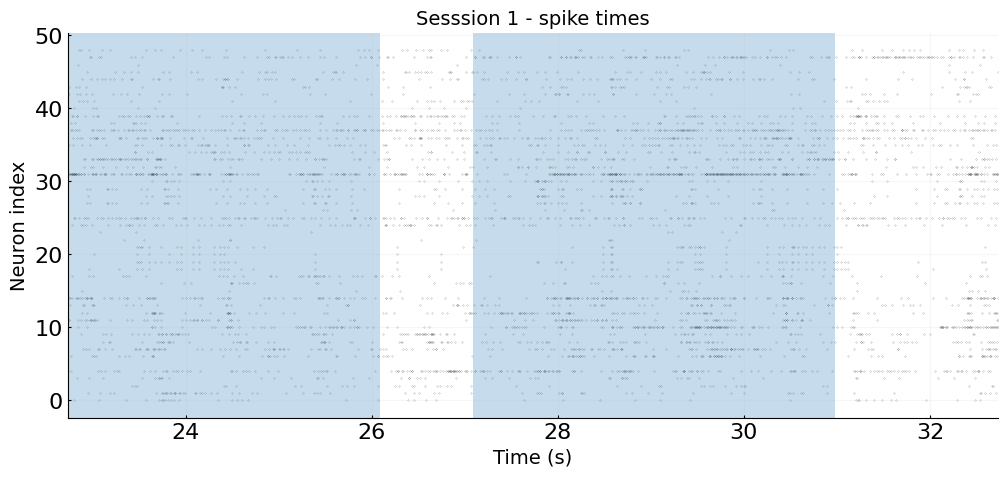

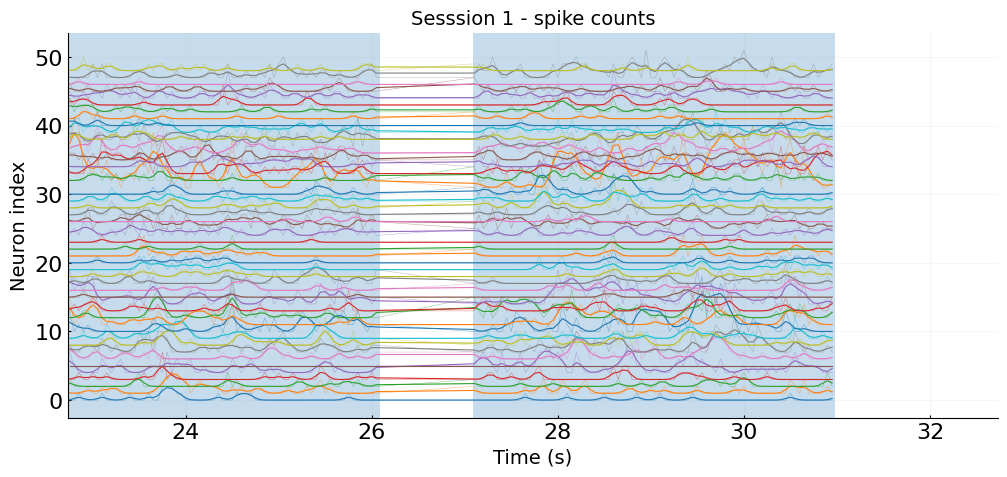

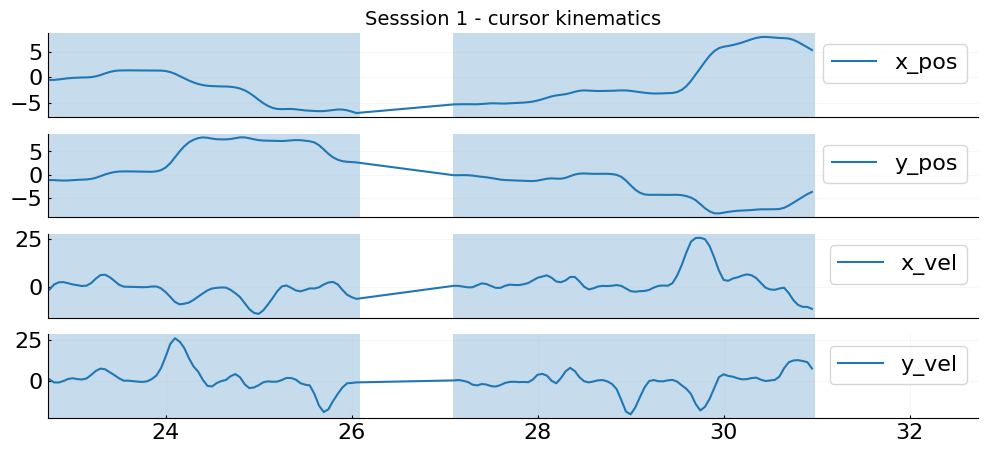

C:\Users\Parsa\AppData\Local\Temp\ipykernel_8864\2063796339.py:98: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


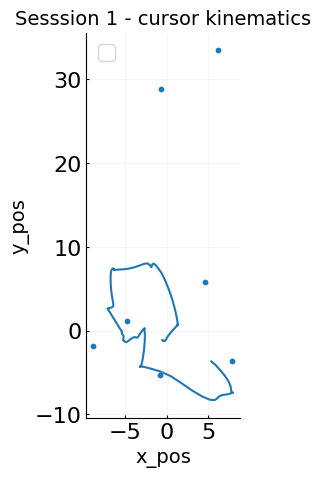

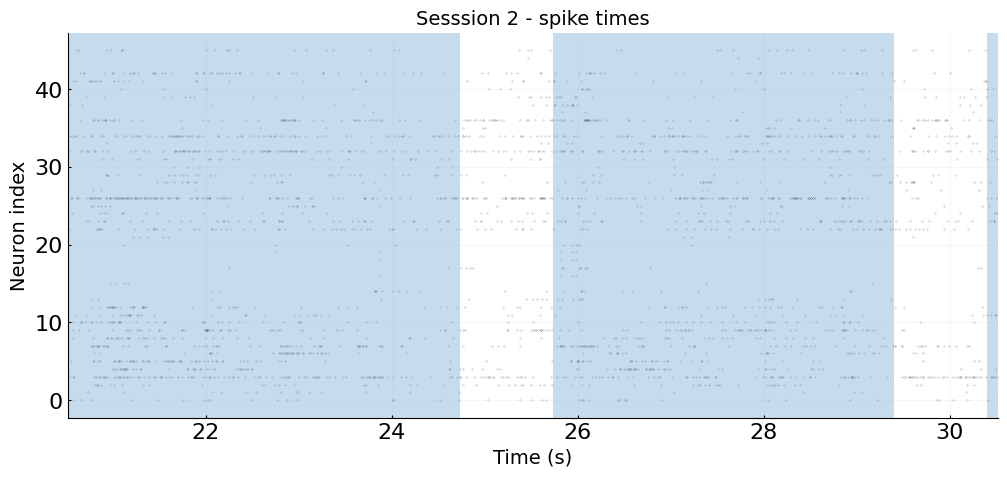

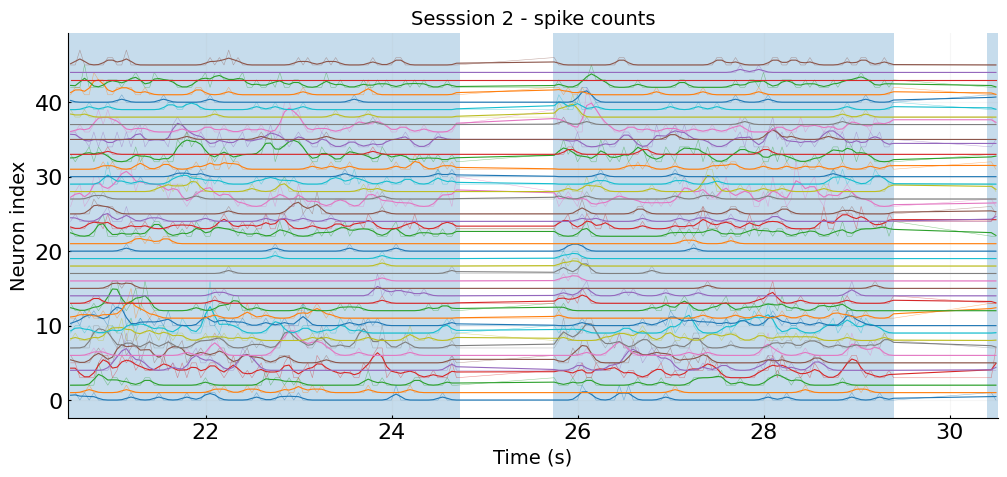

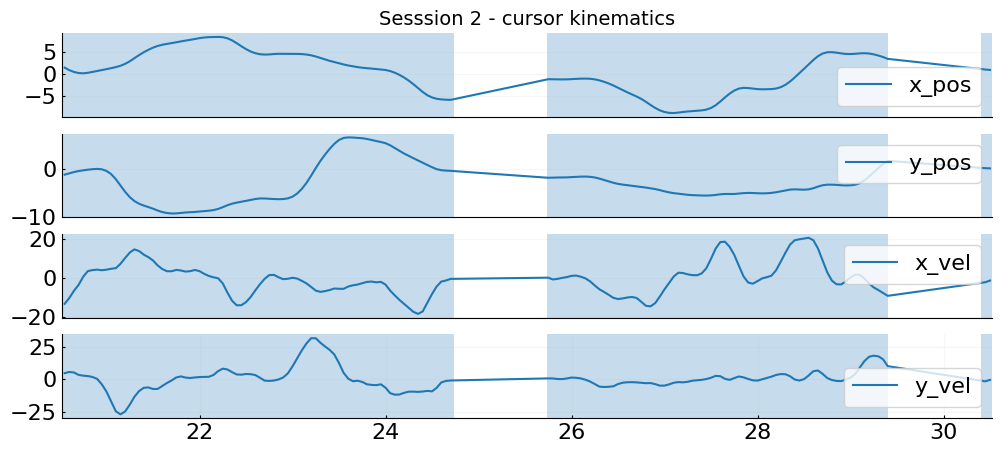

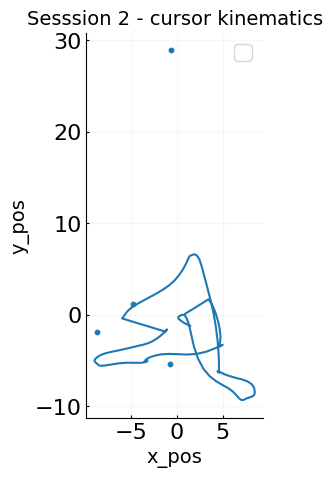

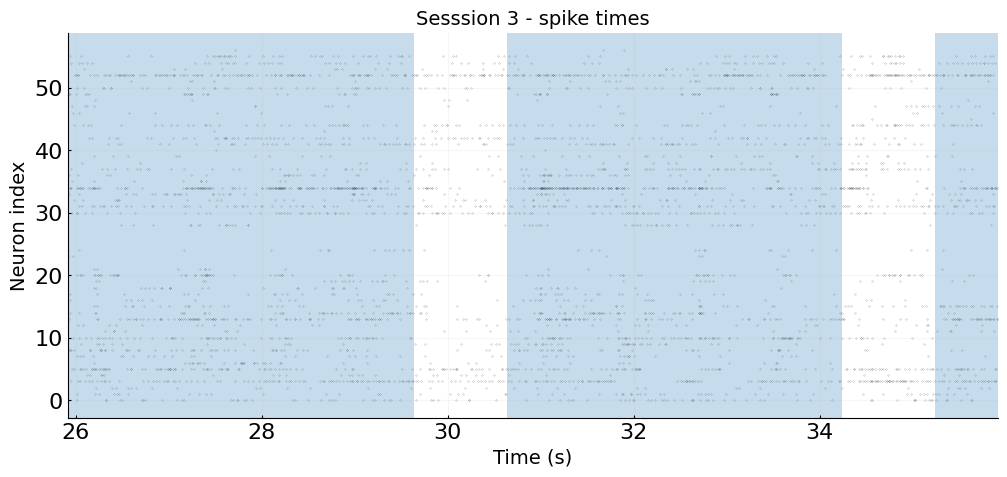

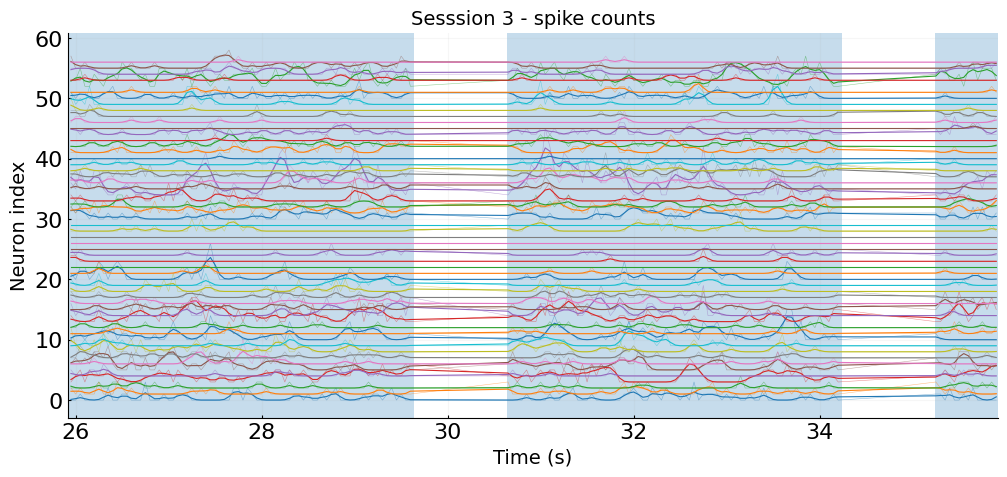

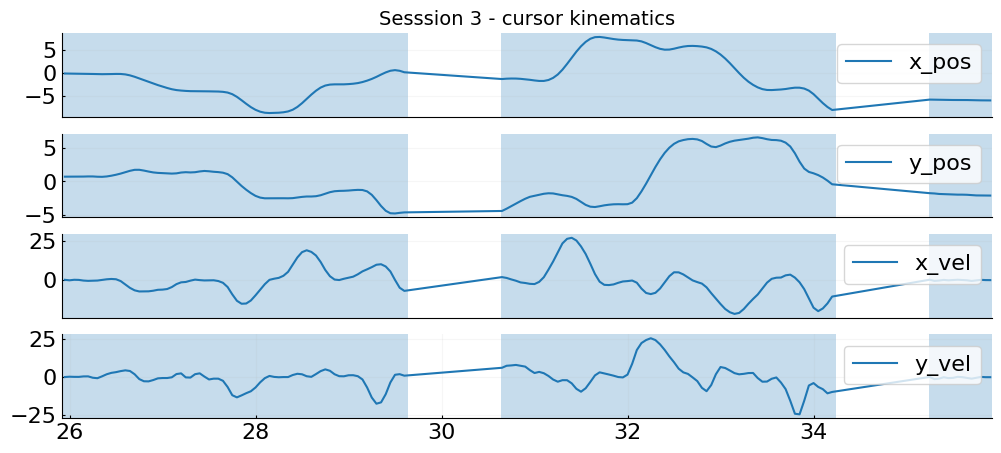

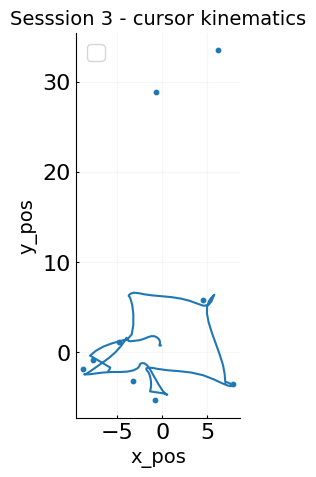

In [6]:
for session_data in all_session_data:
    session = session_data['session']
    trial_start_time = session_data['trial_start_time']
    trial_end_time = session_data['trial_end_time']
    spike_times = session_data['spike_times']
    spike_ids = session_data['spike_ids']
    spike_counts = session_data['spike_counts']
    z_labels = session_data['z_labels']
    tg_times_sortind = np.argsort(tg_times)
    tg_pos = tg_pos[tg_times_sortind, :]
    tg_times = tg_times[tg_times_sortind]
    y = session_data['y']
    z = session_data['z']
    t = session_data['t']
    title_head = f'Sesssion {session} - '
    zoom_period = np.array([trial_start_time[2], trial_start_time[2]+10])
    plotSpikeRaster(spike_times, spike_ids, title_head=title_head, zoom_period=zoom_period, trial_start_time=trial_start_time, trial_end_time=trial_end_time)
    plotSpikeCounts(t, spike_counts, y, title_head=title_head, zoom_period=zoom_period, trial_start_time=trial_start_time, trial_end_time=trial_end_time)
    plotBehavior(t, z, labels=z_labels, title_head=title_head, trial_start_time=trial_start_time, zoom_period=zoom_period, trial_end_time=trial_end_time)
    plotCursorPosition(z, tg_times, tg_pos, labels=z_labels, title_head=title_head, t=t, zoom_period=zoom_period, trial_start_time=trial_start_time, trial_end_time=trial_end_time)

#### Notes:
1) The following procedures needs to be repeated for each fold within each analyzed dataset/session. Here we only model data from fold one of one of the sessions for simplicity. Please refer to FAQ #2 for more on this.
2) Here as an example we set nx=n1=16 for simplicity. Note that in practice, one needs to explore various dimensions and select the number of behaviorally relevant states (n1) and the total number of states (nx) accordingly. Please refer to FAQ #1 for more details on how to select the state dimensions.

    So for example for modeling a dataset including 3 sessions, with 5 cross-validated folds, and exploring 6 different state dimensions (6 different (nx,n1) pairs), one needs to run flexible DPAD/DPAD with user-defined nonlinearity $3*5*6=90$ times. These 90 runs can be done in parallel for efficiency.

## Modeling of neural-behavioral data: Flexible DPAD

### We use flexible DPAD to model the data. 

In [7]:
## Preparing data for session 2 and fold 1/5 for this example. In this example we use 16 dimensional states (all behaviorally relevant).
session_data = all_session_data[1] # Session 2 as an example
allYData = session_data['y'] # Preprocessed neural data
allZData = session_data['z'] # Behavior data
N = allYData.shape[0] # Total number of samples in session 1

# Separate data into training and test data (first fold from a 5-fold cross-validation):
testInds = np.arange(np.round(0.2 * N), dtype=int)
trainInds = np.arange(1 + testInds[-1], N)
yTrain = allYData[trainInds, :]
yTest = allYData[testInds, :]
zTrain = allZData[trainInds, :]
zTest = allZData[testInds, :]

nx = n1 = 16 # In this example we use 16 dimensional states (all behaviorally relevant)

We first run flexible DPAD (step 1.1) to select the nonlionearity resulting in **best behavior decoding** in this dataset. This is the primary goal of DPAD. If interested in the configuration with best neural serlf-prediction instead, please follow the next example where we show how to use flexible DPAD and select the nonlinearity resulting in the best neural self-prediction instead of behavior decoding.

In [ ]:
## Step 1.1: Finding optimal nonlinearity:
# The following function searches over possible nonlinearities and picks the best one based on the training data
settings = {}
settings["min_cores_to_enable_parallelization"] = 100 # If fewer than this many cores are available, code will not run with parallelization,
# set to a large number to disable parallelization
settings['fit_epochs'] = 2500 # Fitting will stop upon convergence or after at most the specified number of epochs. The default (2500 epochs) is
# usually more than enough.

methodCode = "DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16" # sess 1, 2

# This considers 16 case: Each of the 4 mappings with zero (linear) or 1 hidden layer with 64 unit.

saveDir = os.path.join("..", "..", "..", "results") # Where you want the fitting results to be saved

# This functions needs to be called for each session, fold and state dimension. Here we only run it for fold 1 of session 1 and with fixed state dimensions of nx=n1=16 as an example
selectedMethodCode, iCVRes = fitDPADWithFlexibleNonlinearity(
    yTrain, Z=zTrain, nx=nx, n1=n1, settings=settings, methodCode=methodCode, saveDir=saveDir)

print(f'\n\nSelected nonlinearity setting: {selectedMethodCode}')

# Typical runtime for this step:
# - For any individual nonlinearity: a couple of minutes
# - For flexible search over all nonlinearity options:
#   + Without parallelization: sum of run times for all considered nonlinearity options
#   + With full parallelization: max of run time across all considered nonlinearity options

2025-05-30 10:24:26 DPAD.tools.flexible [flexible.py > 249] INFO Running innerCV to choose among the following 16 variants:
(1) DPAD_RTR2_ErSV16
(2) DPAD_RTR2_A1HL64U_ErSV16
(3) DPAD_RTR2_K1HL64U_ErSV16
(4) DPAD_RTR2_Cz1HL64U_ErSV16
(5) DPAD_RTR2_Cy1HL64U_ErSV16
(6) DPAD_RTR2_uAK1HL64U_ErSV16
(7) DPAD_RTR2_ACz1HL64U_ErSV16
(8) DPAD_RTR2_ACy1HL64U_ErSV16
(9) DPAD_RTR2_KCz1HL64U_ErSV16
(10) DPAD_RTR2_KCy1HL64U_ErSV16
(11) DPAD_RTR2_CzCy1HL64U_ErSV16
(12) DPAD_RTR2_uAKCz1HL64U_ErSV16
(13) DPAD_RTR2_uAKCy1HL64U_ErSV16
(14) DPAD_RTR2_ACzCy1HL64U_ErSV16
(15) DPAD_RTR2_KCzCy1HL64U_ErSV16
(16) DPAD_RTR2_uAKCzCy1HL64U_ErSV16
2025-05-30 10:24:26 DPAD.tools.flexible [flexible.py > 637] INFO Assuming new run because no result file was found in ..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p
2025-05-30 10:24:26 DPAD.tools.flexible [flexible.py > 1381] INFO Fold 1/4: training samples: 8014, test samples=2672
2025-05-30 10:24:26 DPAD.tools.flexible [flexible.py > 1754] 

Considering 16 possible combinations of location/type for nonlinearities (this might take a while)...


2025-05-30 10:24:26 DPAD.DPADModel [DPADModel.py > 1525] INFO Stage 1: Learning A11, K1, Cz1 (ZType: cont)
2025-05-30 10:24:26 DPAD.RNNModel [RNNModel.py > 1583] INFO Shifting output by 1 samples to train network for 1-step ahead prediction
2025-05-30 10:24:26 DPAD.RNNModel [RNNModel.py > 1743] INFO Have 4 batches each with 12 128-sample data segments (ny_in=46, ny_out=4, nft=0)
2025-05-30 10:24:26 DPAD.tools.model_base_classes [model_base_classes.py > 226] INFO Starting fit attempt 1 of 2
2025-05-30 10:28:31 DPAD.tools.model_base_classes [model_base_classes.py > 499] INFO 
Epoch 1/2500 - loss=rnn_1step_loss=1.000152, rnn_1step_R2_maskV_-1.0=-0.023116767, rnn_1step_CC_maskV_-1.0=-0.0070318393, rnn_1step_MSE_maskV_-1.0=1.0001521, val_loss=val_rnn_1step_loss=val_rnn_1step_MSE_maskV_-1.0=0.96705598, val_rnn_1step_R2_maskV_-1.0=-0.090282321, val_rnn_1step_CC_maskV_-1.0=0.010060819, learning_rate=0.001
Epoch 251/2500 - loss=rnn_1step_loss=0.42187414, rnn_1step_R2_maskV_-1.0=0.56494141, rnn_

201/201 [==============================] - 0s 721us/step


2025-05-30 10:33:19 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.852, R2_maskV_-1.0=0.147, CC_maskV_-1.0=0.397


51/51 [==============================] - 0s 771us/step


2025-05-30 10:33:20 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 1/4 method "DPAD_RTR2_ErSV16" (1/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f1_4_DPAD_RTR2_ErSV16_nx16.p"
2025-05-30 10:33:20 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 1/4 method "DPAD_RTR2_A1HL64U_ErSV16" (2/16)
2025-05-30 10:33:20 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_A1HL64U_ErSV16 nx=16"
2025-05-30 10:33:20 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs': True, 'optimizer_name': 'Ad

201/201 [==============================] - 0s 766us/step


2025-05-30 10:34:55 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.737, R2_maskV_-1.0=0.265, CC_maskV_-1.0=0.513


84/84 [==============================] - 0s 740us/step


2025-05-30 10:34:56 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 1/4 method "DPAD_RTR2_A1HL64U_ErSV16" (2/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f1_4_DPAD_RTR2_A1HL64U_ErSV16_nx16.p"
2025-05-30 10:34:56 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 1/4 method "DPAD_RTR2_K1HL64U_ErSV16" (3/16)
2025-05-30 10:34:56 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_K1HL64U_ErSV16 nx=16"
2025-05-30 10:34:56 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs': True, 'opti

201/201 [==============================] - 0s 783us/step


2025-05-30 10:37:52 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.813, R2_maskV_-1.0=0.187, CC_maskV_-1.0=0.433


84/84 [==============================] - 0s 767us/step


2025-05-30 10:37:53 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 1/4 method "DPAD_RTR2_K1HL64U_ErSV16" (3/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f1_4_DPAD_RTR2_K1HL64U_ErSV16_nx16.p"
2025-05-30 10:37:53 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 1/4 method "DPAD_RTR2_Cz1HL64U_ErSV16" (4/16)
2025-05-30 10:37:53 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_Cz1HL64U_ErSV16 nx=16"
2025-05-30 10:37:53 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs': True, 'op

201/201 [==============================] - 0s 776us/step


2025-05-30 10:40:36 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.708, R2_maskV_-1.0=0.293, CC_maskV_-1.0=0.54


84/84 [==============================] - 0s 707us/step


2025-05-30 10:40:37 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 1/4 method "DPAD_RTR2_Cz1HL64U_ErSV16" (4/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f1_4_DPAD_RTR2_Cz1HL64U_ErSV16_nx16.p"
2025-05-30 10:40:37 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 1/4 method "DPAD_RTR2_Cy1HL64U_ErSV16" (5/16)
2025-05-30 10:40:37 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_Cy1HL64U_ErSV16 nx=16"
2025-05-30 10:40:37 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs': True, '

201/201 [==============================] - 0s 806us/step


2025-05-30 10:45:41 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.687, R2_maskV_-1.0=0.314, CC_maskV_-1.0=0.56


84/84 [==============================] - 0s 754us/step


2025-05-30 10:45:42 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 1/4 method "DPAD_RTR2_Cy1HL64U_ErSV16" (5/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f1_4_DPAD_RTR2_Cy1HL64U_ErSV16_nx16.p"
2025-05-30 10:45:42 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 1/4 method "DPAD_RTR2_uAK1HL64U_ErSV16" (6/16)
2025-05-30 10:45:42 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_uAK1HL64U_ErSV16 nx=16"
2025-05-30 10:45:42 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs': True,

201/201 [==============================] - 0s 1ms/step


2025-05-30 10:48:47 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.85, R2_maskV_-1.0=0.151, CC_maskV_-1.0=0.389


84/84 [==============================] - 0s 701us/step


2025-05-30 10:48:48 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 1/4 method "DPAD_RTR2_uAK1HL64U_ErSV16" (6/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f1_4_DPAD_RTR2_uAK1HL64U_ErSV16_nx16.p"
2025-05-30 10:48:48 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 1/4 method "DPAD_RTR2_ACz1HL64U_ErSV16" (7/16)
2025-05-30 10:48:48 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_ACz1HL64U_ErSV16 nx=16"
2025-05-30 10:48:48 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs': Tru

201/201 [==============================] - 0s 761us/step


2025-05-30 10:50:21 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.702, R2_maskV_-1.0=0.3, CC_maskV_-1.0=0.546


84/84 [==============================] - 0s 725us/step


2025-05-30 10:50:22 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 1/4 method "DPAD_RTR2_ACz1HL64U_ErSV16" (7/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f1_4_DPAD_RTR2_ACz1HL64U_ErSV16_nx16.p"
2025-05-30 10:50:22 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 1/4 method "DPAD_RTR2_ACy1HL64U_ErSV16" (8/16)
2025-05-30 10:50:22 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_ACy1HL64U_ErSV16 nx=16"
2025-05-30 10:50:22 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs': Tru

201/201 [==============================] - 0s 774us/step


2025-05-30 10:51:48 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.622, R2_maskV_-1.0=0.38, CC_maskV_-1.0=0.615


84/84 [==============================] - 0s 730us/step


2025-05-30 10:51:49 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 1/4 method "DPAD_RTR2_ACy1HL64U_ErSV16" (8/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f1_4_DPAD_RTR2_ACy1HL64U_ErSV16_nx16.p"
2025-05-30 10:51:49 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 1/4 method "DPAD_RTR2_KCz1HL64U_ErSV16" (9/16)
2025-05-30 10:51:49 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_KCz1HL64U_ErSV16 nx=16"
2025-05-30 10:51:49 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs': Tru

201/201 [==============================] - 0s 747us/step


2025-05-30 10:54:45 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.809, R2_maskV_-1.0=0.191, CC_maskV_-1.0=0.438


84/84 [==============================] - 0s 704us/step


2025-05-30 10:54:46 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 1/4 method "DPAD_RTR2_KCz1HL64U_ErSV16" (9/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f1_4_DPAD_RTR2_KCz1HL64U_ErSV16_nx16.p"
2025-05-30 10:54:46 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 1/4 method "DPAD_RTR2_KCy1HL64U_ErSV16" (10/16)
2025-05-30 10:54:46 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_KCy1HL64U_ErSV16 nx=16"
2025-05-30 10:54:46 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs': Tr

201/201 [==============================] - 0s 853us/step


2025-05-30 10:56:39 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.743, R2_maskV_-1.0=0.257, CC_maskV_-1.0=0.507


84/84 [==============================] - 0s 754us/step


2025-05-30 10:56:40 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 1/4 method "DPAD_RTR2_KCy1HL64U_ErSV16" (10/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f1_4_DPAD_RTR2_KCy1HL64U_ErSV16_nx16.p"
2025-05-30 10:56:40 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 1/4 method "DPAD_RTR2_CzCy1HL64U_ErSV16" (11/16)
2025-05-30 10:56:40 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_CzCy1HL64U_ErSV16 nx=16"
2025-05-30 10:56:40 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs':

201/201 [==============================] - 0s 797us/step


2025-05-30 10:58:17 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.621, R2_maskV_-1.0=0.38, CC_maskV_-1.0=0.616


84/84 [==============================] - 0s 751us/step


2025-05-30 10:58:18 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 1/4 method "DPAD_RTR2_CzCy1HL64U_ErSV16" (11/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f1_4_DPAD_RTR2_CzCy1HL64U_ErSV16_nx16.p"
2025-05-30 10:58:18 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 1/4 method "DPAD_RTR2_uAKCz1HL64U_ErSV16" (12/16)
2025-05-30 10:58:18 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_uAKCz1HL64U_ErSV16 nx=16"
2025-05-30 10:58:18 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inpu

201/201 [==============================] - 0s 706us/step


2025-05-30 11:00:53 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.815, R2_maskV_-1.0=0.185, CC_maskV_-1.0=0.431


84/84 [==============================] - 0s 711us/step


2025-05-30 11:00:54 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 1/4 method "DPAD_RTR2_uAKCz1HL64U_ErSV16" (12/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f1_4_DPAD_RTR2_uAKCz1HL64U_ErSV16_nx16.p"
2025-05-30 11:00:54 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 1/4 method "DPAD_RTR2_uAKCy1HL64U_ErSV16" (13/16)
2025-05-30 11:00:54 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_uAKCy1HL64U_ErSV16 nx=16"
2025-05-30 11:00:54 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_in

201/201 [==============================] - 0s 821us/step


2025-05-30 11:03:13 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.716, R2_maskV_-1.0=0.285, CC_maskV_-1.0=0.533


84/84 [==============================] - 0s 765us/step


2025-05-30 11:03:13 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 1/4 method "DPAD_RTR2_uAKCy1HL64U_ErSV16" (13/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f1_4_DPAD_RTR2_uAKCy1HL64U_ErSV16_nx16.p"
2025-05-30 11:03:13 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 1/4 method "DPAD_RTR2_ACzCy1HL64U_ErSV16" (14/16)
2025-05-30 11:03:13 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_ACzCy1HL64U_ErSV16 nx=16"
2025-05-30 11:03:13 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_in

201/201 [==============================] - 0s 777us/step


2025-05-30 11:05:37 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.584, R2_maskV_-1.0=0.417, CC_maskV_-1.0=0.645


84/84 [==============================] - 0s 762us/step


2025-05-30 11:05:38 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 1/4 method "DPAD_RTR2_ACzCy1HL64U_ErSV16" (14/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f1_4_DPAD_RTR2_ACzCy1HL64U_ErSV16_nx16.p"
2025-05-30 11:05:38 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 1/4 method "DPAD_RTR2_KCzCy1HL64U_ErSV16" (15/16)
2025-05-30 11:05:38 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_KCzCy1HL64U_ErSV16 nx=16"
2025-05-30 11:05:38 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_in

201/201 [==============================] - 0s 791us/step


2025-05-30 11:07:45 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.712, R2_maskV_-1.0=0.288, CC_maskV_-1.0=0.536


84/84 [==============================] - 0s 770us/step


2025-05-30 11:07:46 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 1/4 method "DPAD_RTR2_KCzCy1HL64U_ErSV16" (15/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f1_4_DPAD_RTR2_KCzCy1HL64U_ErSV16_nx16.p"
2025-05-30 11:07:46 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 1/4 method "DPAD_RTR2_uAKCzCy1HL64U_ErSV16" (16/16)
2025-05-30 11:07:46 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_uAKCzCy1HL64U_ErSV16 nx=16"
2025-05-30 11:07:46 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscor

201/201 [==============================] - 0s 797us/step


2025-05-30 11:09:58 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.704, R2_maskV_-1.0=0.297, CC_maskV_-1.0=0.544


84/84 [==============================] - 0s 736us/step


2025-05-30 11:09:58 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 1/4 method "DPAD_RTR2_uAKCzCy1HL64U_ErSV16" (16/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f1_4_DPAD_RTR2_uAKCzCy1HL64U_ErSV16_nx16.p"
2025-05-30 11:09:58 DPAD.tools.flexible [flexible.py > 1948] INFO Saving results for fold 1 as ..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f1_4.p
2025-05-30 11:09:58 DPAD.tools.flexible [flexible.py > 1381] INFO Fold 2/4: training samples: 8014, test samples=2672
2025-05-30 11:09:58 DPAD.tools.flexible [flexible.py > 1754] INFO Running fold 2 (NTrain=8014, NTest=2672)
2025-05-30 11:09:58 DPAD.tools.flexible [flexible.py > 1849] INFO Signal dimensions: y => (10686, 46), z => (10686, 4), u => None
2025-05-30 11:09:58 DPAD.tools.flexible [flexible.py > 1856] INFO Method codes to fit: ['DPAD_RTR2_ErSV16', 'DPAD_RTR2_A1HL64U_ErSV16', 'DPAD_RTR2_K1HL64U_ErSV16', 'DPAD_RTR2_Cz1HL64U_ErSV16', 'DP

201/201 [==============================] - 0s 782us/step


2025-05-30 11:12:41 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.76, R2_maskV_-1.0=0.24, CC_maskV_-1.0=0.491


51/51 [==============================] - 0s 788us/step


2025-05-30 11:12:42 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 2/4 method "DPAD_RTR2_ErSV16" (1/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f2_4_DPAD_RTR2_ErSV16_nx16.p"
2025-05-30 11:12:42 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 2/4 method "DPAD_RTR2_A1HL64U_ErSV16" (2/16)
2025-05-30 11:12:42 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_A1HL64U_ErSV16 nx=16"
2025-05-30 11:12:42 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs': True, 'optimizer_name': 'Ad

201/201 [==============================] - 0s 763us/step


2025-05-30 11:14:43 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.731, R2_maskV_-1.0=0.269, CC_maskV_-1.0=0.519


84/84 [==============================] - 0s 733us/step


2025-05-30 11:14:44 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 2/4 method "DPAD_RTR2_A1HL64U_ErSV16" (2/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f2_4_DPAD_RTR2_A1HL64U_ErSV16_nx16.p"
2025-05-30 11:14:44 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 2/4 method "DPAD_RTR2_K1HL64U_ErSV16" (3/16)
2025-05-30 11:14:44 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_K1HL64U_ErSV16 nx=16"
2025-05-30 11:14:44 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs': True, 'opti

201/201 [==============================] - 0s 704us/step


2025-05-30 11:18:41 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.81, R2_maskV_-1.0=0.189, CC_maskV_-1.0=0.438


84/84 [==============================] - 0s 674us/step


2025-05-30 11:18:42 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 2/4 method "DPAD_RTR2_K1HL64U_ErSV16" (3/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f2_4_DPAD_RTR2_K1HL64U_ErSV16_nx16.p"
2025-05-30 11:18:42 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 2/4 method "DPAD_RTR2_Cz1HL64U_ErSV16" (4/16)
2025-05-30 11:18:42 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_Cz1HL64U_ErSV16 nx=16"
2025-05-30 11:18:42 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs': True, 'op

201/201 [==============================] - 0s 739us/step


2025-05-30 11:20:16 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.722, R2_maskV_-1.0=0.278, CC_maskV_-1.0=0.528


84/84 [==============================] - 0s 705us/step


2025-05-30 11:20:16 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 2/4 method "DPAD_RTR2_Cz1HL64U_ErSV16" (4/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f2_4_DPAD_RTR2_Cz1HL64U_ErSV16_nx16.p"
2025-05-30 11:20:16 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 2/4 method "DPAD_RTR2_Cy1HL64U_ErSV16" (5/16)
2025-05-30 11:20:16 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_Cy1HL64U_ErSV16 nx=16"
2025-05-30 11:20:16 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs': True, '

201/201 [==============================] - 0s 753us/step


2025-05-30 11:22:18 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.633, R2_maskV_-1.0=0.369, CC_maskV_-1.0=0.607


84/84 [==============================] - 0s 865us/step


2025-05-30 11:22:19 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 2/4 method "DPAD_RTR2_Cy1HL64U_ErSV16" (5/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f2_4_DPAD_RTR2_Cy1HL64U_ErSV16_nx16.p"
2025-05-30 11:22:19 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 2/4 method "DPAD_RTR2_uAK1HL64U_ErSV16" (6/16)
2025-05-30 11:22:19 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_uAK1HL64U_ErSV16 nx=16"
2025-05-30 11:22:19 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs': True,

201/201 [==============================] - 0s 750us/step


2025-05-30 11:25:15 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.851, R2_maskV_-1.0=0.149, CC_maskV_-1.0=0.389


84/84 [==============================] - 0s 711us/step


2025-05-30 11:25:16 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 2/4 method "DPAD_RTR2_uAK1HL64U_ErSV16" (6/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f2_4_DPAD_RTR2_uAK1HL64U_ErSV16_nx16.p"
2025-05-30 11:25:16 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 2/4 method "DPAD_RTR2_ACz1HL64U_ErSV16" (7/16)
2025-05-30 11:25:16 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_ACz1HL64U_ErSV16 nx=16"
2025-05-30 11:25:16 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs': Tru

201/201 [==============================] - 0s 741us/step


2025-05-30 11:26:44 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.71, R2_maskV_-1.0=0.291, CC_maskV_-1.0=0.539


84/84 [==============================] - 0s 733us/step


2025-05-30 11:26:45 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 2/4 method "DPAD_RTR2_ACz1HL64U_ErSV16" (7/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f2_4_DPAD_RTR2_ACz1HL64U_ErSV16_nx16.p"
2025-05-30 11:26:45 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 2/4 method "DPAD_RTR2_ACy1HL64U_ErSV16" (8/16)
2025-05-30 11:26:45 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_ACy1HL64U_ErSV16 nx=16"
2025-05-30 11:26:45 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs': Tru

201/201 [==============================] - 0s 789us/step


2025-05-30 11:28:29 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.595, R2_maskV_-1.0=0.407, CC_maskV_-1.0=0.637


84/84 [==============================] - 0s 979us/step


2025-05-30 11:28:29 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 2/4 method "DPAD_RTR2_ACy1HL64U_ErSV16" (8/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f2_4_DPAD_RTR2_ACy1HL64U_ErSV16_nx16.p"
2025-05-30 11:28:29 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 2/4 method "DPAD_RTR2_KCz1HL64U_ErSV16" (9/16)
2025-05-30 11:28:29 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_KCz1HL64U_ErSV16 nx=16"
2025-05-30 11:28:29 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs': Tru

201/201 [==============================] - 0s 698us/step


2025-05-30 11:31:28 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.801, R2_maskV_-1.0=0.198, CC_maskV_-1.0=0.448


84/84 [==============================] - 0s 709us/step


2025-05-30 11:31:29 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 2/4 method "DPAD_RTR2_KCz1HL64U_ErSV16" (9/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f2_4_DPAD_RTR2_KCz1HL64U_ErSV16_nx16.p"
2025-05-30 11:31:29 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 2/4 method "DPAD_RTR2_KCy1HL64U_ErSV16" (10/16)
2025-05-30 11:31:29 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_KCy1HL64U_ErSV16 nx=16"
2025-05-30 11:31:29 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs': Tr

201/201 [==============================] - 0s 854us/step


2025-05-30 11:33:22 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.72, R2_maskV_-1.0=0.279, CC_maskV_-1.0=0.529


84/84 [==============================] - 0s 725us/step


2025-05-30 11:33:23 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 2/4 method "DPAD_RTR2_KCy1HL64U_ErSV16" (10/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f2_4_DPAD_RTR2_KCy1HL64U_ErSV16_nx16.p"
2025-05-30 11:33:23 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 2/4 method "DPAD_RTR2_CzCy1HL64U_ErSV16" (11/16)
2025-05-30 11:33:23 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_CzCy1HL64U_ErSV16 nx=16"
2025-05-30 11:33:23 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs':

201/201 [==============================] - 0s 792us/step


2025-05-30 11:35:49 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.612, R2_maskV_-1.0=0.389, CC_maskV_-1.0=0.623


84/84 [==============================] - 0s 697us/step


2025-05-30 11:35:49 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 2/4 method "DPAD_RTR2_CzCy1HL64U_ErSV16" (11/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f2_4_DPAD_RTR2_CzCy1HL64U_ErSV16_nx16.p"
2025-05-30 11:35:49 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 2/4 method "DPAD_RTR2_uAKCz1HL64U_ErSV16" (12/16)
2025-05-30 11:35:49 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_uAKCz1HL64U_ErSV16 nx=16"
2025-05-30 11:35:49 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inpu

201/201 [==============================] - 0s 779us/step


2025-05-30 11:38:23 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.827, R2_maskV_-1.0=0.173, CC_maskV_-1.0=0.418


84/84 [==============================] - 0s 703us/step


2025-05-30 11:38:24 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 2/4 method "DPAD_RTR2_uAKCz1HL64U_ErSV16" (12/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f2_4_DPAD_RTR2_uAKCz1HL64U_ErSV16_nx16.p"
2025-05-30 11:38:24 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 2/4 method "DPAD_RTR2_uAKCy1HL64U_ErSV16" (13/16)
2025-05-30 11:38:24 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_uAKCy1HL64U_ErSV16 nx=16"
2025-05-30 11:38:24 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_in

201/201 [==============================] - 0s 818us/step


2025-05-30 11:40:18 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.725, R2_maskV_-1.0=0.276, CC_maskV_-1.0=0.525


84/84 [==============================] - 0s 797us/step


2025-05-30 11:40:18 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 2/4 method "DPAD_RTR2_uAKCy1HL64U_ErSV16" (13/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f2_4_DPAD_RTR2_uAKCy1HL64U_ErSV16_nx16.p"
2025-05-30 11:40:19 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 2/4 method "DPAD_RTR2_ACzCy1HL64U_ErSV16" (14/16)
2025-05-30 11:40:19 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_ACzCy1HL64U_ErSV16 nx=16"
2025-05-30 11:40:19 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_in

201/201 [==============================] - 0s 873us/step


2025-05-30 11:42:22 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.6, R2_maskV_-1.0=0.401, CC_maskV_-1.0=0.633


84/84 [==============================] - 0s 932us/step


2025-05-30 11:42:24 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 2/4 method "DPAD_RTR2_ACzCy1HL64U_ErSV16" (14/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f2_4_DPAD_RTR2_ACzCy1HL64U_ErSV16_nx16.p"
2025-05-30 11:42:24 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 2/4 method "DPAD_RTR2_KCzCy1HL64U_ErSV16" (15/16)
2025-05-30 11:42:24 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_KCzCy1HL64U_ErSV16 nx=16"
2025-05-30 11:42:24 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_in

201/201 [==============================] - 0s 796us/step


2025-05-30 11:43:56 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.731, R2_maskV_-1.0=0.268, CC_maskV_-1.0=0.519


84/84 [==============================] - 0s 761us/step


2025-05-30 11:43:57 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 2/4 method "DPAD_RTR2_KCzCy1HL64U_ErSV16" (15/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f2_4_DPAD_RTR2_KCzCy1HL64U_ErSV16_nx16.p"
2025-05-30 11:43:57 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 2/4 method "DPAD_RTR2_uAKCzCy1HL64U_ErSV16" (16/16)
2025-05-30 11:43:57 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_uAKCzCy1HL64U_ErSV16 nx=16"
2025-05-30 11:43:57 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscor

201/201 [==============================] - 0s 800us/step


2025-05-30 11:45:28 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.723, R2_maskV_-1.0=0.278, CC_maskV_-1.0=0.527


84/84 [==============================] - 0s 817us/step


2025-05-30 11:45:29 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 2/4 method "DPAD_RTR2_uAKCzCy1HL64U_ErSV16" (16/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f2_4_DPAD_RTR2_uAKCzCy1HL64U_ErSV16_nx16.p"
2025-05-30 11:45:29 DPAD.tools.flexible [flexible.py > 1948] INFO Saving results for fold 2 as ..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f2_4.p
2025-05-30 11:45:29 DPAD.tools.flexible [flexible.py > 1381] INFO Fold 3/4: training samples: 8014, test samples=2672
2025-05-30 11:45:29 DPAD.tools.flexible [flexible.py > 1754] INFO Running fold 3 (NTrain=8014, NTest=2672)
2025-05-30 11:45:29 DPAD.tools.flexible [flexible.py > 1849] INFO Signal dimensions: y => (10686, 46), z => (10686, 4), u => None
2025-05-30 11:45:29 DPAD.tools.flexible [flexible.py > 1856] INFO Method codes to fit: ['DPAD_RTR2_ErSV16', 'DPAD_RTR2_A1HL64U_ErSV16', 'DPAD_RTR2_K1HL64U_ErSV16', 'DPAD_RTR2_Cz1HL64U_ErSV16', 'DP

201/201 [==============================] - 0s 757us/step


2025-05-30 11:47:37 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.736, R2_maskV_-1.0=0.264, CC_maskV_-1.0=0.515


51/51 [==============================] - 0s 774us/step


2025-05-30 11:47:37 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 3/4 method "DPAD_RTR2_ErSV16" (1/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f3_4_DPAD_RTR2_ErSV16_nx16.p"
2025-05-30 11:47:37 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 3/4 method "DPAD_RTR2_A1HL64U_ErSV16" (2/16)
2025-05-30 11:47:37 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_A1HL64U_ErSV16 nx=16"
2025-05-30 11:47:37 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs': True, 'optimizer_name': 'Ad

201/201 [==============================] - 0s 776us/step


2025-05-30 11:49:15 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.726, R2_maskV_-1.0=0.274, CC_maskV_-1.0=0.524


84/84 [==============================] - 0s 676us/step


2025-05-30 11:49:16 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 3/4 method "DPAD_RTR2_A1HL64U_ErSV16" (2/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f3_4_DPAD_RTR2_A1HL64U_ErSV16_nx16.p"
2025-05-30 11:49:16 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 3/4 method "DPAD_RTR2_K1HL64U_ErSV16" (3/16)
2025-05-30 11:49:16 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_K1HL64U_ErSV16 nx=16"
2025-05-30 11:49:16 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs': True, 'opti

201/201 [==============================] - 0s 762us/step


2025-05-30 11:52:15 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.819, R2_maskV_-1.0=0.18, CC_maskV_-1.0=0.428


84/84 [==============================] - 0s 725us/step


2025-05-30 11:52:16 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 3/4 method "DPAD_RTR2_K1HL64U_ErSV16" (3/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f3_4_DPAD_RTR2_K1HL64U_ErSV16_nx16.p"
2025-05-30 11:52:16 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 3/4 method "DPAD_RTR2_Cz1HL64U_ErSV16" (4/16)
2025-05-30 11:52:16 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_Cz1HL64U_ErSV16 nx=16"
2025-05-30 11:52:16 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs': True, 'op

201/201 [==============================] - 0s 752us/step


2025-05-30 11:54:35 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.715, R2_maskV_-1.0=0.285, CC_maskV_-1.0=0.534


84/84 [==============================] - 0s 730us/step


2025-05-30 11:54:36 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 3/4 method "DPAD_RTR2_Cz1HL64U_ErSV16" (4/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f3_4_DPAD_RTR2_Cz1HL64U_ErSV16_nx16.p"
2025-05-30 11:54:36 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 3/4 method "DPAD_RTR2_Cy1HL64U_ErSV16" (5/16)
2025-05-30 11:54:36 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_Cy1HL64U_ErSV16 nx=16"
2025-05-30 11:54:36 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs': True, '

201/201 [==============================] - 0s 817us/step


2025-05-30 11:57:01 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.619, R2_maskV_-1.0=0.384, CC_maskV_-1.0=0.617


84/84 [==============================] - 0s 732us/step


2025-05-30 11:57:02 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 3/4 method "DPAD_RTR2_Cy1HL64U_ErSV16" (5/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f3_4_DPAD_RTR2_Cy1HL64U_ErSV16_nx16.p"
2025-05-30 11:57:02 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 3/4 method "DPAD_RTR2_uAK1HL64U_ErSV16" (6/16)
2025-05-30 11:57:02 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_uAK1HL64U_ErSV16 nx=16"
2025-05-30 11:57:02 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs': True,

201/201 [==============================] - 0s 737us/step


2025-05-30 12:01:03 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.824, R2_maskV_-1.0=0.176, CC_maskV_-1.0=0.42


84/84 [==============================] - 0s 674us/step


2025-05-30 12:01:04 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 3/4 method "DPAD_RTR2_uAK1HL64U_ErSV16" (6/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f3_4_DPAD_RTR2_uAK1HL64U_ErSV16_nx16.p"
2025-05-30 12:01:04 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 3/4 method "DPAD_RTR2_ACz1HL64U_ErSV16" (7/16)
2025-05-30 12:01:04 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_ACz1HL64U_ErSV16 nx=16"
2025-05-30 12:01:04 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs': Tru

201/201 [==============================] - 0s 736us/step


2025-05-30 12:02:39 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.708, R2_maskV_-1.0=0.291, CC_maskV_-1.0=0.54


84/84 [==============================] - 0s 685us/step


2025-05-30 12:02:40 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 3/4 method "DPAD_RTR2_ACz1HL64U_ErSV16" (7/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f3_4_DPAD_RTR2_ACz1HL64U_ErSV16_nx16.p"
2025-05-30 12:02:40 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 3/4 method "DPAD_RTR2_ACy1HL64U_ErSV16" (8/16)
2025-05-30 12:02:40 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_ACy1HL64U_ErSV16 nx=16"
2025-05-30 12:02:40 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs': Tru

201/201 [==============================] - 0s 823us/step


2025-05-30 12:04:42 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.577, R2_maskV_-1.0=0.426, CC_maskV_-1.0=0.651


84/84 [==============================] - 0s 853us/step


2025-05-30 12:04:43 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 3/4 method "DPAD_RTR2_ACy1HL64U_ErSV16" (8/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f3_4_DPAD_RTR2_ACy1HL64U_ErSV16_nx16.p"
2025-05-30 12:04:43 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 3/4 method "DPAD_RTR2_KCz1HL64U_ErSV16" (9/16)
2025-05-30 12:04:43 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_KCz1HL64U_ErSV16 nx=16"
2025-05-30 12:04:43 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs': Tru

201/201 [==============================] - 0s 754us/step


2025-05-30 12:09:00 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.8, R2_maskV_-1.0=0.2, CC_maskV_-1.0=0.449


84/84 [==============================] - 0s 709us/step


2025-05-30 12:09:00 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 3/4 method "DPAD_RTR2_KCz1HL64U_ErSV16" (9/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f3_4_DPAD_RTR2_KCz1HL64U_ErSV16_nx16.p"
2025-05-30 12:09:00 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 3/4 method "DPAD_RTR2_KCy1HL64U_ErSV16" (10/16)
2025-05-30 12:09:00 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_KCy1HL64U_ErSV16 nx=16"
2025-05-30 12:09:00 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs': Tr

201/201 [==============================] - 0s 828us/step


2025-05-30 12:11:11 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.704, R2_maskV_-1.0=0.296, CC_maskV_-1.0=0.544


84/84 [==============================] - 0s 787us/step


2025-05-30 12:11:12 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 3/4 method "DPAD_RTR2_KCy1HL64U_ErSV16" (10/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f3_4_DPAD_RTR2_KCy1HL64U_ErSV16_nx16.p"
2025-05-30 12:11:12 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 3/4 method "DPAD_RTR2_CzCy1HL64U_ErSV16" (11/16)
2025-05-30 12:11:12 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_CzCy1HL64U_ErSV16 nx=16"
2025-05-30 12:11:12 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs':

201/201 [==============================] - 0s 795us/step


2025-05-30 12:12:45 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.61, R2_maskV_-1.0=0.392, CC_maskV_-1.0=0.625


84/84 [==============================] - 0s 719us/step


2025-05-30 12:12:46 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 3/4 method "DPAD_RTR2_CzCy1HL64U_ErSV16" (11/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f3_4_DPAD_RTR2_CzCy1HL64U_ErSV16_nx16.p"
2025-05-30 12:12:46 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 3/4 method "DPAD_RTR2_uAKCz1HL64U_ErSV16" (12/16)
2025-05-30 12:12:46 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_uAKCz1HL64U_ErSV16 nx=16"
2025-05-30 12:12:46 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inpu

201/201 [==============================] - 0s 754us/step


2025-05-30 12:16:00 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.807, R2_maskV_-1.0=0.194, CC_maskV_-1.0=0.442


84/84 [==============================] - 0s 718us/step


2025-05-30 12:16:00 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 3/4 method "DPAD_RTR2_uAKCz1HL64U_ErSV16" (12/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f3_4_DPAD_RTR2_uAKCz1HL64U_ErSV16_nx16.p"
2025-05-30 12:16:00 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 3/4 method "DPAD_RTR2_uAKCy1HL64U_ErSV16" (13/16)
2025-05-30 12:16:00 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_uAKCy1HL64U_ErSV16 nx=16"
2025-05-30 12:16:00 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_in

201/201 [==============================] - 0s 795us/step


2025-05-30 12:18:11 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.7, R2_maskV_-1.0=0.301, CC_maskV_-1.0=0.548


84/84 [==============================] - 0s 737us/step


2025-05-30 12:18:12 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 3/4 method "DPAD_RTR2_uAKCy1HL64U_ErSV16" (13/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f3_4_DPAD_RTR2_uAKCy1HL64U_ErSV16_nx16.p"
2025-05-30 12:18:12 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 3/4 method "DPAD_RTR2_ACzCy1HL64U_ErSV16" (14/16)
2025-05-30 12:18:12 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_ACzCy1HL64U_ErSV16 nx=16"
2025-05-30 12:18:12 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_in

201/201 [==============================] - 0s 810us/step


2025-05-30 12:20:07 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.592, R2_maskV_-1.0=0.41, CC_maskV_-1.0=0.639


84/84 [==============================] - 0s 757us/step


2025-05-30 12:20:08 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 3/4 method "DPAD_RTR2_ACzCy1HL64U_ErSV16" (14/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f3_4_DPAD_RTR2_ACzCy1HL64U_ErSV16_nx16.p"
2025-05-30 12:20:08 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 3/4 method "DPAD_RTR2_KCzCy1HL64U_ErSV16" (15/16)
2025-05-30 12:20:08 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_KCzCy1HL64U_ErSV16 nx=16"
2025-05-30 12:20:08 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_in

201/201 [==============================] - 0s 813us/step


2025-05-30 12:22:12 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.724, R2_maskV_-1.0=0.276, CC_maskV_-1.0=0.526


84/84 [==============================] - 0s 749us/step


2025-05-30 12:22:13 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 3/4 method "DPAD_RTR2_KCzCy1HL64U_ErSV16" (15/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f3_4_DPAD_RTR2_KCzCy1HL64U_ErSV16_nx16.p"
2025-05-30 12:22:13 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 3/4 method "DPAD_RTR2_uAKCzCy1HL64U_ErSV16" (16/16)
2025-05-30 12:22:13 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_uAKCzCy1HL64U_ErSV16 nx=16"
2025-05-30 12:22:13 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscor

201/201 [==============================] - 0s 818us/step


2025-05-30 12:24:07 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.713, R2_maskV_-1.0=0.288, CC_maskV_-1.0=0.536


84/84 [==============================] - 0s 741us/step


2025-05-30 12:24:07 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 3/4 method "DPAD_RTR2_uAKCzCy1HL64U_ErSV16" (16/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f3_4_DPAD_RTR2_uAKCzCy1HL64U_ErSV16_nx16.p"
2025-05-30 12:24:07 DPAD.tools.flexible [flexible.py > 1948] INFO Saving results for fold 3 as ..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f3_4.p
2025-05-30 12:24:07 DPAD.tools.flexible [flexible.py > 1381] INFO Fold 4/4: training samples: 8016, test samples=2670
2025-05-30 12:24:07 DPAD.tools.flexible [flexible.py > 1754] INFO Running fold 4 (NTrain=8016, NTest=2670)
2025-05-30 12:24:07 DPAD.tools.flexible [flexible.py > 1849] INFO Signal dimensions: y => (10686, 46), z => (10686, 4), u => None
2025-05-30 12:24:07 DPAD.tools.flexible [flexible.py > 1856] INFO Method codes to fit: ['DPAD_RTR2_ErSV16', 'DPAD_RTR2_A1HL64U_ErSV16', 'DPAD_RTR2_K1HL64U_ErSV16', 'DPAD_RTR2_Cz1HL64U_ErSV16', 'DP

201/201 [==============================] - 0s 768us/step


2025-05-30 12:26:22 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.762, R2_maskV_-1.0=0.238, CC_maskV_-1.0=0.49


51/51 [==============================] - 0s 758us/step


2025-05-30 12:26:23 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 4/4 method "DPAD_RTR2_ErSV16" (1/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f4_4_DPAD_RTR2_ErSV16_nx16.p"
2025-05-30 12:26:23 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 4/4 method "DPAD_RTR2_A1HL64U_ErSV16" (2/16)
2025-05-30 12:26:23 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_A1HL64U_ErSV16 nx=16"
2025-05-30 12:26:23 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs': True, 'optimizer_name': 'Ad

201/201 [==============================] - 0s 763us/step


2025-05-30 12:27:58 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.737, R2_maskV_-1.0=0.264, CC_maskV_-1.0=0.514


84/84 [==============================] - 0s 1ms/step


2025-05-30 12:27:59 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 4/4 method "DPAD_RTR2_A1HL64U_ErSV16" (2/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f4_4_DPAD_RTR2_A1HL64U_ErSV16_nx16.p"
2025-05-30 12:27:59 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 4/4 method "DPAD_RTR2_K1HL64U_ErSV16" (3/16)
2025-05-30 12:27:59 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_K1HL64U_ErSV16 nx=16"
2025-05-30 12:27:59 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs': True, 'opti

201/201 [==============================] - 0s 714us/step


2025-05-30 12:31:29 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.82, R2_maskV_-1.0=0.179, CC_maskV_-1.0=0.428


84/84 [==============================] - 0s 716us/step


2025-05-30 12:31:30 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 4/4 method "DPAD_RTR2_K1HL64U_ErSV16" (3/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f4_4_DPAD_RTR2_K1HL64U_ErSV16_nx16.p"
2025-05-30 12:31:30 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 4/4 method "DPAD_RTR2_Cz1HL64U_ErSV16" (4/16)
2025-05-30 12:31:30 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_Cz1HL64U_ErSV16 nx=16"
2025-05-30 12:31:30 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs': True, 'op

201/201 [==============================] - 0s 742us/step


2025-05-30 12:33:51 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.721, R2_maskV_-1.0=0.279, CC_maskV_-1.0=0.529


84/84 [==============================] - 0s 690us/step


2025-05-30 12:33:51 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 4/4 method "DPAD_RTR2_Cz1HL64U_ErSV16" (4/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f4_4_DPAD_RTR2_Cz1HL64U_ErSV16_nx16.p"
2025-05-30 12:33:51 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 4/4 method "DPAD_RTR2_Cy1HL64U_ErSV16" (5/16)
2025-05-30 12:33:51 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_Cy1HL64U_ErSV16 nx=16"
2025-05-30 12:33:51 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs': True, '

201/201 [==============================] - 0s 794us/step


2025-05-30 12:35:53 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.66, R2_maskV_-1.0=0.342, CC_maskV_-1.0=0.584


84/84 [==============================] - 0s 768us/step


2025-05-30 12:35:54 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 4/4 method "DPAD_RTR2_Cy1HL64U_ErSV16" (5/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f4_4_DPAD_RTR2_Cy1HL64U_ErSV16_nx16.p"
2025-05-30 12:35:54 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 4/4 method "DPAD_RTR2_uAK1HL64U_ErSV16" (6/16)
2025-05-30 12:35:54 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_uAK1HL64U_ErSV16 nx=16"
2025-05-30 12:35:54 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs': True,

201/201 [==============================] - 0s 715us/step


2025-05-30 12:39:55 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.847, R2_maskV_-1.0=0.154, CC_maskV_-1.0=0.393


84/84 [==============================] - 0s 708us/step


2025-05-30 12:39:55 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 4/4 method "DPAD_RTR2_uAK1HL64U_ErSV16" (6/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f4_4_DPAD_RTR2_uAK1HL64U_ErSV16_nx16.p"
2025-05-30 12:39:55 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 4/4 method "DPAD_RTR2_ACz1HL64U_ErSV16" (7/16)
2025-05-30 12:39:55 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_ACz1HL64U_ErSV16 nx=16"
2025-05-30 12:39:55 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs': Tru

201/201 [==============================] - 0s 749us/step


2025-05-30 12:42:14 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.717, R2_maskV_-1.0=0.282, CC_maskV_-1.0=0.532


84/84 [==============================] - 0s 686us/step


2025-05-30 12:42:15 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 4/4 method "DPAD_RTR2_ACz1HL64U_ErSV16" (7/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f4_4_DPAD_RTR2_ACz1HL64U_ErSV16_nx16.p"
2025-05-30 12:42:15 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 4/4 method "DPAD_RTR2_ACy1HL64U_ErSV16" (8/16)
2025-05-30 12:42:15 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_ACy1HL64U_ErSV16 nx=16"
2025-05-30 12:42:15 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs': Tru

201/201 [==============================] - 0s 814us/step


2025-05-30 12:45:09 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.618, R2_maskV_-1.0=0.384, CC_maskV_-1.0=0.618


84/84 [==============================] - 0s 835us/step


2025-05-30 12:45:09 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 4/4 method "DPAD_RTR2_ACy1HL64U_ErSV16" (8/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f4_4_DPAD_RTR2_ACy1HL64U_ErSV16_nx16.p"
2025-05-30 12:45:09 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 4/4 method "DPAD_RTR2_KCz1HL64U_ErSV16" (9/16)
2025-05-30 12:45:09 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_KCz1HL64U_ErSV16 nx=16"
2025-05-30 12:45:09 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs': Tru

201/201 [==============================] - 0s 751us/step


2025-05-30 12:47:29 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.812, R2_maskV_-1.0=0.186, CC_maskV_-1.0=0.434


84/84 [==============================] - 0s 686us/step


2025-05-30 12:47:30 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 4/4 method "DPAD_RTR2_KCz1HL64U_ErSV16" (9/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f4_4_DPAD_RTR2_KCz1HL64U_ErSV16_nx16.p"
2025-05-30 12:47:30 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 4/4 method "DPAD_RTR2_KCy1HL64U_ErSV16" (10/16)
2025-05-30 12:47:30 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_KCy1HL64U_ErSV16 nx=16"
2025-05-30 12:47:30 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs': Tr

201/201 [==============================] - 0s 931us/step


2025-05-30 12:49:26 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.716, R2_maskV_-1.0=0.284, CC_maskV_-1.0=0.534


84/84 [==============================] - 0s 865us/step


2025-05-30 12:49:27 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 4/4 method "DPAD_RTR2_KCy1HL64U_ErSV16" (10/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f4_4_DPAD_RTR2_KCy1HL64U_ErSV16_nx16.p"
2025-05-30 12:49:27 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 4/4 method "DPAD_RTR2_CzCy1HL64U_ErSV16" (11/16)
2025-05-30 12:49:27 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_CzCy1HL64U_ErSV16 nx=16"
2025-05-30 12:49:27 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs':

201/201 [==============================] - 0s 814us/step


2025-05-30 12:51:56 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.614, R2_maskV_-1.0=0.387, CC_maskV_-1.0=0.622


84/84 [==============================] - 0s 709us/step


2025-05-30 12:51:56 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 4/4 method "DPAD_RTR2_CzCy1HL64U_ErSV16" (11/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f4_4_DPAD_RTR2_CzCy1HL64U_ErSV16_nx16.p"
2025-05-30 12:51:56 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 4/4 method "DPAD_RTR2_uAKCz1HL64U_ErSV16" (12/16)
2025-05-30 12:51:56 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_uAKCz1HL64U_ErSV16 nx=16"
2025-05-30 12:51:56 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inpu

201/201 [==============================] - 0s 799us/step


2025-05-30 12:54:55 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.817, R2_maskV_-1.0=0.182, CC_maskV_-1.0=0.429


84/84 [==============================] - 0s 684us/step


2025-05-30 12:54:56 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 4/4 method "DPAD_RTR2_uAKCz1HL64U_ErSV16" (12/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f4_4_DPAD_RTR2_uAKCz1HL64U_ErSV16_nx16.p"
2025-05-30 12:54:56 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 4/4 method "DPAD_RTR2_uAKCy1HL64U_ErSV16" (13/16)
2025-05-30 12:54:56 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_uAKCy1HL64U_ErSV16 nx=16"
2025-05-30 12:54:56 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_in

201/201 [==============================] - 0s 823us/step


2025-05-30 12:57:13 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.714, R2_maskV_-1.0=0.287, CC_maskV_-1.0=0.536


84/84 [==============================] - 0s 769us/step


2025-05-30 12:57:14 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 4/4 method "DPAD_RTR2_uAKCy1HL64U_ErSV16" (13/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f4_4_DPAD_RTR2_uAKCy1HL64U_ErSV16_nx16.p"
2025-05-30 12:57:14 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 4/4 method "DPAD_RTR2_ACzCy1HL64U_ErSV16" (14/16)
2025-05-30 12:57:14 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_ACzCy1HL64U_ErSV16 nx=16"
2025-05-30 12:57:14 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_in

201/201 [==============================] - 0s 817us/step


2025-05-30 12:59:18 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.62, R2_maskV_-1.0=0.379, CC_maskV_-1.0=0.617


84/84 [==============================] - 0s 754us/step


2025-05-30 12:59:19 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 4/4 method "DPAD_RTR2_ACzCy1HL64U_ErSV16" (14/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f4_4_DPAD_RTR2_ACzCy1HL64U_ErSV16_nx16.p"
2025-05-30 12:59:19 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 4/4 method "DPAD_RTR2_KCzCy1HL64U_ErSV16" (15/16)
2025-05-30 12:59:19 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_KCzCy1HL64U_ErSV16 nx=16"
2025-05-30 12:59:19 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_in

201/201 [==============================] - 0s 800us/step


2025-05-30 13:01:19 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.712, R2_maskV_-1.0=0.285, CC_maskV_-1.0=0.538


84/84 [==============================] - 0s 685us/step


2025-05-30 13:01:20 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 4/4 method "DPAD_RTR2_KCzCy1HL64U_ErSV16" (15/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f4_4_DPAD_RTR2_KCzCy1HL64U_ErSV16_nx16.p"
2025-05-30 13:01:20 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 4/4 method "DPAD_RTR2_uAKCzCy1HL64U_ErSV16" (16/16)
2025-05-30 13:01:20 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_uAKCzCy1HL64U_ErSV16 nx=16"
2025-05-30 13:01:20 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscor

201/201 [==============================] - 0s 785us/step


2025-05-30 13:04:12 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.691, R2_maskV_-1.0=0.31, CC_maskV_-1.0=0.556


84/84 [==============================] - 0s 763us/step


2025-05-30 13:04:13 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 4/4 method "DPAD_RTR2_uAKCzCy1HL64U_ErSV16" (16/16) in "..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f4_4_DPAD_RTR2_uAKCzCy1HL64U_ErSV16_nx16.p"
2025-05-30 13:04:13 DPAD.tools.flexible [flexible.py > 1948] INFO Saving results for fold 4 as ..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f4_4.p
2025-05-30 13:04:14 DPAD.tools.flexible [flexible.py > 4212] INFO Saving the results in ..\..\results\8d238f30_683d1f05_N\DPAD_GSUT_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p
2025-05-30 13:04:14 DPAD.tools.flexible [flexible.py > 4110] INFO Checking whether result file size could be reduced for future loads
2025-05-30 13:04:14 DPAD.tools.flexible [flexible.py > 4199] INFO Could not reduce file size
2025-05-30 13:04:14 DPAD.tools.flexible [flexible.py > 320] INFO Selecting among the 16 tried method variants based on the inner CV results: 
2025-05-30 13:0



Selected nonlinearity setting: DPAD_RTR2_KCzCy1HL64U_ErSV16


As the last line of the log shows, in this example the optimal nonlinearity giving rise to best behavior (z) decoding is: `DPAD_RTR2_KCzCy1HL64U_ErSV16` : $K$, $C_z$ and $C_y$ nonlinear.

> To Complete flexible DPAD runs, you need to set `methodCode=selectedMethodCode` (for best behavior decoding i.e., default) or `methodCode=selectedMethodCode_y` (for best neural self-prediction) obtained above and run DPAD again according to next section.

> You can alternatively set `methodCode` manually to run DPAD with your desired user-defined nonlinearity e.g., nonlinear Cz: `methodCode='DPAD_RTR2_Cz1HL64U_ErSV16'`. Please see `2. DPAD with user-defined nonlinearity` above for more explanation.

In [10]:
## Step 1.2: Fitting DPAD with optimal nonlinearity
##  or 
## simply running DPAD with user-defined nonlinearity

# ATTENTION: To complete the flexible DPAD, you need to first run the previous cell and pass methodCode=selectedMethodCode this section:
methodCode = selectedMethodCode
# Alternatively, to skip the flexible search, you can run this cell on its own by simply setting methodCode to the desired nonlinearity settings. For example, you can set:
# methodCode = 'DPAD_RTR2_Cz1HL64U_ErSV16' # To run DPAD with nonlinearity in Cz only.

idSysF = DPADModel()
epochs = 2500  # Default for this is 2500.
# Fitting will stop upon convergence or after at most the specified number of
# epochs. 2500 as the max number of epochs is usually more than enough.
# Here for speed, we can set to something lower, expecting that the decoding
# will not reach that of the true model unless the number of epochs is large
# enough for convergence

# Prepare settings to make desired parameters in the learned model nonlinear
args = DPADModel.prepare_args(methodCode)
idSysF.fit(yTrain.T, Z=zTrain.T, nx=nx, n1=n1, epochs=epochs, **args)


2025-05-30 13:46:55 DPAD.DPADModel [DPADModel.py > 907] INFO Early stopping measure is "val_loss". Includes validation loss, so we will ignore any provided validation data and creating validation data fom the training data to avoid overfitting
2025-05-30 13:46:55 DPAD.DPADModel [DPADModel.py > 1525] INFO Stage 1: Learning A11, K1, Cz1 (ZType: cont)
2025-05-30 13:46:55 DPAD.RNNModel [RNNModel.py > 1583] INFO Shifting output by 1 samples to train network for 1-step ahead prediction
2025-05-30 13:46:55 DPAD.RNNModel [RNNModel.py > 1743] INFO Have 4 batches each with 16 128-sample data segments (ny_in=46, ny_out=4, nft=0)
2025-05-30 13:46:55 DPAD.tools.model_base_classes [model_base_classes.py > 226] INFO Starting fit attempt 1 of 2
2025-05-30 13:47:09 DPAD.tools.model_base_classes [model_base_classes.py > 114] INFO Restoring model weights from the end of the best epoch: 109 (stopped at 124 epochs).
2025-05-30 13:47:09 DPAD.tools.model_base_classes [model_base_classes.py > 499] INFO 
Epoch

268/268 [==============================] - 0s 760us/step


2025-05-30 13:48:56 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_None=0.76, R2_maskV_None=0.29, CC_maskV_None=0.69


67/67 [==============================] - 0s 844us/step


After fitting is done, you can infer the 1-step-ahead predicted states, neural activity and behavior as follows

In [ ]:
# Predict behavior and neural activity, from past neural activity, using the learned model
print("Computing predictions for the learned model with optimal nonlinearity for behavior decoding")
###########
zTestPredF, yTestPredF, xTestPredF = idSysF.predict(yTest)

# Compute CC of decoding and self-prediction
zCCNonLinF = evalPrediction(zTest, zTestPredF, "CC")
yCCNonLinF = evalPrediction(yTest, yTestPredF, "CC")
##########

print(
    f"Behavior decoding CC:\n  Nonlinear DPAD (Flexible; best nonlinearity for behavior decoidng) => {np.mean(zCCNonLinF):.3g}"
)



Computing predictions for the learned model with optimal nonlinearity for behavior decoding
84/84 [==============================] - 0s 771us/step
Behavior decoding CC:
  Nonlinear DPAD (Flexible; best nonlinearity for behavior decoidng) => 0.793


This is how you can plot the learning curve:

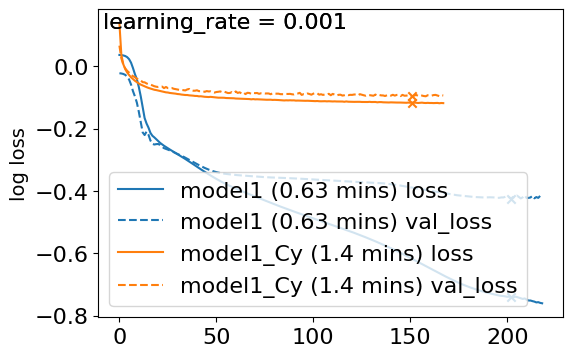

(<Figure size 600x400 with 1 Axes>, <Axes: ylabel='log loss'>)

In [12]:
idSysF.plot_logs()

Let's now run flexible DPAD for best nonlinearity for neural self-prediction:\
If alternatively interested in optimized neural self-prediction, you can make use the following by adding **'y'** to 'GSUT' in the method code as 'GSUTy' and fitting the flexible DPAD with this updated method code as follows:

In [13]:
## Step 1.1: Finding optimal nonlinearity (based on self-prediction of y (neural activity):
# The following function searches over possible nonlinearities and picks the best one based on the training data
settings = {}
settings["min_cores_to_enable_parallelization"] = 100 # If fewer than this many cores are available, code will not run with parallelization,
# set to a large number to disable parallelization
settings['fit_epochs'] = 2500 # Fitting will stop upon convergence or after at most the specified number of epochs. The default (2500 epochs) is

methodCode_y = "DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16" # Note that 'GSUT has changed to GSUTy to denote that performance measure for selection is based on prediction of y.

saveDir = os.path.join("..", "..", "..", "results") # Where you want the fitting results to be saved

# This functions needs to be called for each session, fold and state dimension. Here we only run it for fold 1 of session 1 and with fixed state dimensions of nx=n1=16 as an example
selectedMethodCode_y, iCVRes_y = fitDPADWithFlexibleNonlinearity(
    yTrain, Z=zTrain, nx=nx, n1=n1, settings=settings, methodCode=methodCode_y, saveDir=saveDir)

print(f'\n\nSelected nonlinearity setting for best neural self-prediction: {selectedMethodCode_y}')

2025-05-30 14:27:31 DPAD.tools.flexible [flexible.py > 249] INFO Running innerCV to choose among the following 16 variants:
(1) DPAD_RTR2_ErSV16
(2) DPAD_RTR2_A1HL64U_ErSV16
(3) DPAD_RTR2_K1HL64U_ErSV16
(4) DPAD_RTR2_Cz1HL64U_ErSV16
(5) DPAD_RTR2_Cy1HL64U_ErSV16
(6) DPAD_RTR2_uAK1HL64U_ErSV16
(7) DPAD_RTR2_ACz1HL64U_ErSV16
(8) DPAD_RTR2_ACy1HL64U_ErSV16
(9) DPAD_RTR2_KCz1HL64U_ErSV16
(10) DPAD_RTR2_KCy1HL64U_ErSV16
(11) DPAD_RTR2_CzCy1HL64U_ErSV16
(12) DPAD_RTR2_uAKCz1HL64U_ErSV16
(13) DPAD_RTR2_uAKCy1HL64U_ErSV16
(14) DPAD_RTR2_ACzCy1HL64U_ErSV16
(15) DPAD_RTR2_KCzCy1HL64U_ErSV16
(16) DPAD_RTR2_uAKCzCy1HL64U_ErSV16
2025-05-30 14:27:31 DPAD.tools.flexible [flexible.py > 637] INFO Assuming new run because no result file was found in ..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p
2025-05-30 14:27:31 DPAD.tools.flexible [flexible.py > 1381] INFO Fold 1/4: training samples: 8014, test samples=2672
2025-05-30 14:27:31 DPAD.tools.flexible [flexible.py > 17

Considering 16 possible combinations of location/type for nonlinearities (this might take a while)...


2025-05-30 14:27:31 DPAD.DPADModel [DPADModel.py > 1525] INFO Stage 1: Learning A11, K1, Cz1 (ZType: cont)
2025-05-30 14:27:31 DPAD.RNNModel [RNNModel.py > 1583] INFO Shifting output by 1 samples to train network for 1-step ahead prediction
2025-05-30 14:27:31 DPAD.RNNModel [RNNModel.py > 1743] INFO Have 4 batches each with 12 128-sample data segments (ny_in=46, ny_out=4, nft=0)
2025-05-30 14:27:31 DPAD.tools.model_base_classes [model_base_classes.py > 226] INFO Starting fit attempt 1 of 2
2025-05-30 14:31:07 DPAD.tools.model_base_classes [model_base_classes.py > 499] INFO 
Epoch 1/2500 - loss=rnn_1step_loss=0.99842739, rnn_1step_R2_maskV_-1.0=-0.021439366, rnn_1step_CC_maskV_-1.0=0.03259721, rnn_1step_MSE_maskV_-1.0=0.99842733, val_loss=val_rnn_1step_loss=val_rnn_1step_MSE_maskV_-1.0=0.96488094, val_rnn_1step_R2_maskV_-1.0=-0.087740093, val_rnn_1step_CC_maskV_-1.0=0.057965536, learning_rate=0.001
Epoch 251/2500 - loss=rnn_1step_loss=rnn_1step_MSE_maskV_-1.0=0.4227643, rnn_1step_R2_mas

201/201 [==============================] - 0s 711us/step


2025-05-30 14:32:26 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.842, R2_maskV_-1.0=0.158, CC_maskV_-1.0=0.407


51/51 [==============================] - 0s 753us/step


2025-05-30 14:32:26 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 1/4 method "DPAD_RTR2_ErSV16" (1/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f1_4_DPAD_RTR2_ErSV16_nx16.p"
2025-05-30 14:32:26 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 1/4 method "DPAD_RTR2_A1HL64U_ErSV16" (2/16)
2025-05-30 14:32:26 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_A1HL64U_ErSV16 nx=16"
2025-05-30 14:32:26 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs': True, 'optimizer_name':

201/201 [==============================] - 0s 732us/step


2025-05-30 14:34:26 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.741, R2_maskV_-1.0=0.26, CC_maskV_-1.0=0.509


84/84 [==============================] - 0s 720us/step


2025-05-30 14:34:27 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 1/4 method "DPAD_RTR2_A1HL64U_ErSV16" (2/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f1_4_DPAD_RTR2_A1HL64U_ErSV16_nx16.p"
2025-05-30 14:34:27 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 1/4 method "DPAD_RTR2_K1HL64U_ErSV16" (3/16)
2025-05-30 14:34:27 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_K1HL64U_ErSV16 nx=16"
2025-05-30 14:34:27 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs': True, '

201/201 [==============================] - 0s 705us/step


2025-05-30 14:37:40 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.813, R2_maskV_-1.0=0.187, CC_maskV_-1.0=0.435


84/84 [==============================] - 0s 682us/step


2025-05-30 14:37:41 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 1/4 method "DPAD_RTR2_K1HL64U_ErSV16" (3/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f1_4_DPAD_RTR2_K1HL64U_ErSV16_nx16.p"
2025-05-30 14:37:41 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 1/4 method "DPAD_RTR2_Cz1HL64U_ErSV16" (4/16)
2025-05-30 14:37:41 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_Cz1HL64U_ErSV16 nx=16"
2025-05-30 14:37:41 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs': True,

201/201 [==============================] - 0s 726us/step


2025-05-30 14:39:58 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.718, R2_maskV_-1.0=0.283, CC_maskV_-1.0=0.531


84/84 [==============================] - 0s 731us/step


2025-05-30 14:39:58 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 1/4 method "DPAD_RTR2_Cz1HL64U_ErSV16" (4/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f1_4_DPAD_RTR2_Cz1HL64U_ErSV16_nx16.p"
2025-05-30 14:39:58 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 1/4 method "DPAD_RTR2_Cy1HL64U_ErSV16" (5/16)
2025-05-30 14:39:58 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_Cy1HL64U_ErSV16 nx=16"
2025-05-30 14:39:58 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs': Tru

201/201 [==============================] - 0s 743us/step


2025-05-30 14:46:41 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.713, R2_maskV_-1.0=0.288, CC_maskV_-1.0=0.536


84/84 [==============================] - 0s 768us/step


2025-05-30 14:46:41 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 1/4 method "DPAD_RTR2_Cy1HL64U_ErSV16" (5/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f1_4_DPAD_RTR2_Cy1HL64U_ErSV16_nx16.p"
2025-05-30 14:46:41 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 1/4 method "DPAD_RTR2_uAK1HL64U_ErSV16" (6/16)
2025-05-30 14:46:41 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_uAK1HL64U_ErSV16 nx=16"
2025-05-30 14:46:41 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs': T

201/201 [==============================] - 0s 726us/step


2025-05-30 14:49:40 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.836, R2_maskV_-1.0=0.164, CC_maskV_-1.0=0.407


84/84 [==============================] - 0s 679us/step


2025-05-30 14:49:40 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 1/4 method "DPAD_RTR2_uAK1HL64U_ErSV16" (6/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f1_4_DPAD_RTR2_uAK1HL64U_ErSV16_nx16.p"
2025-05-30 14:49:40 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 1/4 method "DPAD_RTR2_ACz1HL64U_ErSV16" (7/16)
2025-05-30 14:49:40 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_ACz1HL64U_ErSV16 nx=16"
2025-05-30 14:49:40 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs':

201/201 [==============================] - 0s 681us/step


2025-05-30 14:51:19 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.703, R2_maskV_-1.0=0.298, CC_maskV_-1.0=0.545


84/84 [==============================] - 0s 640us/step


2025-05-30 14:51:20 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 1/4 method "DPAD_RTR2_ACz1HL64U_ErSV16" (7/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f1_4_DPAD_RTR2_ACz1HL64U_ErSV16_nx16.p"
2025-05-30 14:51:20 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 1/4 method "DPAD_RTR2_ACy1HL64U_ErSV16" (8/16)
2025-05-30 14:51:20 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_ACy1HL64U_ErSV16 nx=16"
2025-05-30 14:51:20 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs':

201/201 [==============================] - 0s 779us/step


2025-05-30 14:53:11 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.594, R2_maskV_-1.0=0.408, CC_maskV_-1.0=0.637


84/84 [==============================] - 0s 718us/step


2025-05-30 14:53:11 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 1/4 method "DPAD_RTR2_ACy1HL64U_ErSV16" (8/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f1_4_DPAD_RTR2_ACy1HL64U_ErSV16_nx16.p"
2025-05-30 14:53:11 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 1/4 method "DPAD_RTR2_KCz1HL64U_ErSV16" (9/16)
2025-05-30 14:53:11 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_KCz1HL64U_ErSV16 nx=16"
2025-05-30 14:53:11 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs':

201/201 [==============================] - 0s 746us/step


2025-05-30 14:57:04 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.794, R2_maskV_-1.0=0.206, CC_maskV_-1.0=0.455


84/84 [==============================] - 0s 670us/step


2025-05-30 14:57:05 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 1/4 method "DPAD_RTR2_KCz1HL64U_ErSV16" (9/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f1_4_DPAD_RTR2_KCz1HL64U_ErSV16_nx16.p"
2025-05-30 14:57:05 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 1/4 method "DPAD_RTR2_KCy1HL64U_ErSV16" (10/16)
2025-05-30 14:57:05 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_KCy1HL64U_ErSV16 nx=16"
2025-05-30 14:57:05 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs'

201/201 [==============================] - 0s 753us/step


2025-05-30 14:59:10 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.725, R2_maskV_-1.0=0.277, CC_maskV_-1.0=0.525


84/84 [==============================] - 0s 723us/step


2025-05-30 14:59:11 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 1/4 method "DPAD_RTR2_KCy1HL64U_ErSV16" (10/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f1_4_DPAD_RTR2_KCy1HL64U_ErSV16_nx16.p"
2025-05-30 14:59:11 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 1/4 method "DPAD_RTR2_CzCy1HL64U_ErSV16" (11/16)
2025-05-30 14:59:11 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_CzCy1HL64U_ErSV16 nx=16"
2025-05-30 14:59:11 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inpu

201/201 [==============================] - 0s 786us/step


2025-05-30 15:01:02 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.618, R2_maskV_-1.0=0.383, CC_maskV_-1.0=0.618


84/84 [==============================] - 0s 732us/step


2025-05-30 15:01:03 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 1/4 method "DPAD_RTR2_CzCy1HL64U_ErSV16" (11/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f1_4_DPAD_RTR2_CzCy1HL64U_ErSV16_nx16.p"
2025-05-30 15:01:03 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 1/4 method "DPAD_RTR2_uAKCz1HL64U_ErSV16" (12/16)
2025-05-30 15:01:03 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_uAKCz1HL64U_ErSV16 nx=16"
2025-05-30 15:01:03 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_

201/201 [==============================] - 0s 698us/step


2025-05-30 15:03:24 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.819, R2_maskV_-1.0=0.181, CC_maskV_-1.0=0.428


84/84 [==============================] - 0s 673us/step


2025-05-30 15:03:25 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 1/4 method "DPAD_RTR2_uAKCz1HL64U_ErSV16" (12/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f1_4_DPAD_RTR2_uAKCz1HL64U_ErSV16_nx16.p"
2025-05-30 15:03:25 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 1/4 method "DPAD_RTR2_uAKCy1HL64U_ErSV16" (13/16)
2025-05-30 15:03:25 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_uAKCy1HL64U_ErSV16 nx=16"
2025-05-30 15:03:25 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscor

201/201 [==============================] - 0s 761us/step


2025-05-30 15:05:24 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.705, R2_maskV_-1.0=0.296, CC_maskV_-1.0=0.543


84/84 [==============================] - 0s 740us/step


2025-05-30 15:05:25 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 1/4 method "DPAD_RTR2_uAKCy1HL64U_ErSV16" (13/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f1_4_DPAD_RTR2_uAKCy1HL64U_ErSV16_nx16.p"
2025-05-30 15:05:25 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 1/4 method "DPAD_RTR2_ACzCy1HL64U_ErSV16" (14/16)
2025-05-30 15:05:25 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_ACzCy1HL64U_ErSV16 nx=16"
2025-05-30 15:05:25 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscor

201/201 [==============================] - 0s 744us/step


2025-05-30 15:07:25 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.576, R2_maskV_-1.0=0.426, CC_maskV_-1.0=0.651


84/84 [==============================] - 0s 762us/step


2025-05-30 15:07:25 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 1/4 method "DPAD_RTR2_ACzCy1HL64U_ErSV16" (14/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f1_4_DPAD_RTR2_ACzCy1HL64U_ErSV16_nx16.p"
2025-05-30 15:07:25 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 1/4 method "DPAD_RTR2_KCzCy1HL64U_ErSV16" (15/16)
2025-05-30 15:07:25 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_KCzCy1HL64U_ErSV16 nx=16"
2025-05-30 15:07:25 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscor

201/201 [==============================] - 0s 763us/step


2025-05-30 15:09:37 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.696, R2_maskV_-1.0=0.306, CC_maskV_-1.0=0.552


84/84 [==============================] - 0s 685us/step


2025-05-30 15:09:38 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 1/4 method "DPAD_RTR2_KCzCy1HL64U_ErSV16" (15/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f1_4_DPAD_RTR2_KCzCy1HL64U_ErSV16_nx16.p"
2025-05-30 15:09:38 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 1/4 method "DPAD_RTR2_uAKCzCy1HL64U_ErSV16" (16/16)
2025-05-30 15:09:38 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_uAKCzCy1HL64U_ErSV16 nx=16"
2025-05-30 15:09:38 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'z

201/201 [==============================] - 0s 748us/step


2025-05-30 15:11:28 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.716, R2_maskV_-1.0=0.285, CC_maskV_-1.0=0.533


84/84 [==============================] - 0s 737us/step


2025-05-30 15:11:28 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 1/4 method "DPAD_RTR2_uAKCzCy1HL64U_ErSV16" (16/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f1_4_DPAD_RTR2_uAKCzCy1HL64U_ErSV16_nx16.p"
2025-05-30 15:11:28 DPAD.tools.flexible [flexible.py > 1948] INFO Saving results for fold 1 as ..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f1_4.p
2025-05-30 15:11:28 DPAD.tools.flexible [flexible.py > 1381] INFO Fold 2/4: training samples: 8014, test samples=2672
2025-05-30 15:11:28 DPAD.tools.flexible [flexible.py > 1754] INFO Running fold 2 (NTrain=8014, NTest=2672)
2025-05-30 15:11:28 DPAD.tools.flexible [flexible.py > 1849] INFO Signal dimensions: y => (10686, 46), z => (10686, 4), u => None
2025-05-30 15:11:28 DPAD.tools.flexible [flexible.py > 1856] INFO Method codes to fit: ['DPAD_RTR2_ErSV16', 'DPAD_RTR2_A1HL64U_ErSV16', 'DPAD_RTR2_K1HL64U_ErSV16', 'DPAD_RTR2_Cz1HL64U_ErSV

201/201 [==============================] - 0s 710us/step


2025-05-30 15:13:32 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.724, R2_maskV_-1.0=0.278, CC_maskV_-1.0=0.527


51/51 [==============================] - 0s 770us/step


2025-05-30 15:13:32 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 2/4 method "DPAD_RTR2_ErSV16" (1/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f2_4_DPAD_RTR2_ErSV16_nx16.p"
2025-05-30 15:13:32 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 2/4 method "DPAD_RTR2_A1HL64U_ErSV16" (2/16)
2025-05-30 15:13:32 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_A1HL64U_ErSV16 nx=16"
2025-05-30 15:13:32 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs': True, 'optimizer_name':

201/201 [==============================] - 0s 727us/step


2025-05-30 15:15:14 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.74, R2_maskV_-1.0=0.26, CC_maskV_-1.0=0.51


84/84 [==============================] - 0s 670us/step


2025-05-30 15:15:15 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 2/4 method "DPAD_RTR2_A1HL64U_ErSV16" (2/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f2_4_DPAD_RTR2_A1HL64U_ErSV16_nx16.p"
2025-05-30 15:15:15 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 2/4 method "DPAD_RTR2_K1HL64U_ErSV16" (3/16)
2025-05-30 15:15:15 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_K1HL64U_ErSV16 nx=16"
2025-05-30 15:15:15 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs': True, '

201/201 [==============================] - 0s 694us/step


2025-05-30 15:17:36 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.826, R2_maskV_-1.0=0.173, CC_maskV_-1.0=0.421


84/84 [==============================] - 0s 679us/step


2025-05-30 15:17:37 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 2/4 method "DPAD_RTR2_K1HL64U_ErSV16" (3/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f2_4_DPAD_RTR2_K1HL64U_ErSV16_nx16.p"
2025-05-30 15:17:37 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 2/4 method "DPAD_RTR2_Cz1HL64U_ErSV16" (4/16)
2025-05-30 15:17:37 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_Cz1HL64U_ErSV16 nx=16"
2025-05-30 15:17:37 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs': True,

201/201 [==============================] - 0s 688us/step


2025-05-30 15:20:10 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.708, R2_maskV_-1.0=0.292, CC_maskV_-1.0=0.541


84/84 [==============================] - 0s 646us/step


2025-05-30 15:20:10 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 2/4 method "DPAD_RTR2_Cz1HL64U_ErSV16" (4/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f2_4_DPAD_RTR2_Cz1HL64U_ErSV16_nx16.p"
2025-05-30 15:20:10 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 2/4 method "DPAD_RTR2_Cy1HL64U_ErSV16" (5/16)
2025-05-30 15:20:10 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_Cy1HL64U_ErSV16 nx=16"
2025-05-30 15:20:10 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs': Tru

201/201 [==============================] - 0s 726us/step


2025-05-30 15:22:19 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.659, R2_maskV_-1.0=0.343, CC_maskV_-1.0=0.585


84/84 [==============================] - 0s 729us/step


2025-05-30 15:22:19 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 2/4 method "DPAD_RTR2_Cy1HL64U_ErSV16" (5/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f2_4_DPAD_RTR2_Cy1HL64U_ErSV16_nx16.p"
2025-05-30 15:22:19 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 2/4 method "DPAD_RTR2_uAK1HL64U_ErSV16" (6/16)
2025-05-30 15:22:19 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_uAK1HL64U_ErSV16 nx=16"
2025-05-30 15:22:19 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs': T

201/201 [==============================] - 0s 706us/step


2025-05-30 15:24:47 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.836, R2_maskV_-1.0=0.165, CC_maskV_-1.0=0.408


84/84 [==============================] - 0s 663us/step


2025-05-30 15:24:48 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 2/4 method "DPAD_RTR2_uAK1HL64U_ErSV16" (6/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f2_4_DPAD_RTR2_uAK1HL64U_ErSV16_nx16.p"
2025-05-30 15:24:48 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 2/4 method "DPAD_RTR2_ACz1HL64U_ErSV16" (7/16)
2025-05-30 15:24:48 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_ACz1HL64U_ErSV16 nx=16"
2025-05-30 15:24:48 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs':

201/201 [==============================] - 0s 724us/step


2025-05-30 15:26:32 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.719, R2_maskV_-1.0=0.281, CC_maskV_-1.0=0.531


84/84 [==============================] - 0s 628us/step


2025-05-30 15:26:33 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 2/4 method "DPAD_RTR2_ACz1HL64U_ErSV16" (7/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f2_4_DPAD_RTR2_ACz1HL64U_ErSV16_nx16.p"
2025-05-30 15:26:33 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 2/4 method "DPAD_RTR2_ACy1HL64U_ErSV16" (8/16)
2025-05-30 15:26:33 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_ACy1HL64U_ErSV16 nx=16"
2025-05-30 15:26:33 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs':

201/201 [==============================] - 0s 764us/step


2025-05-30 15:28:45 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.597, R2_maskV_-1.0=0.403, CC_maskV_-1.0=0.635


84/84 [==============================] - 0s 742us/step


2025-05-30 15:28:46 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 2/4 method "DPAD_RTR2_ACy1HL64U_ErSV16" (8/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f2_4_DPAD_RTR2_ACy1HL64U_ErSV16_nx16.p"
2025-05-30 15:28:46 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 2/4 method "DPAD_RTR2_KCz1HL64U_ErSV16" (9/16)
2025-05-30 15:28:46 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_KCz1HL64U_ErSV16 nx=16"
2025-05-30 15:28:46 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs':

201/201 [==============================] - 0s 753us/step


2025-05-30 15:31:44 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.794, R2_maskV_-1.0=0.205, CC_maskV_-1.0=0.455


84/84 [==============================] - 0s 722us/step


2025-05-30 15:31:44 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 2/4 method "DPAD_RTR2_KCz1HL64U_ErSV16" (9/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f2_4_DPAD_RTR2_KCz1HL64U_ErSV16_nx16.p"
2025-05-30 15:31:44 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 2/4 method "DPAD_RTR2_KCy1HL64U_ErSV16" (10/16)
2025-05-30 15:31:44 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_KCy1HL64U_ErSV16 nx=16"
2025-05-30 15:31:44 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs'

201/201 [==============================] - 0s 766us/step


2025-05-30 15:33:38 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.744, R2_maskV_-1.0=0.257, CC_maskV_-1.0=0.507


84/84 [==============================] - 0s 754us/step


2025-05-30 15:33:38 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 2/4 method "DPAD_RTR2_KCy1HL64U_ErSV16" (10/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f2_4_DPAD_RTR2_KCy1HL64U_ErSV16_nx16.p"
2025-05-30 15:33:38 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 2/4 method "DPAD_RTR2_CzCy1HL64U_ErSV16" (11/16)
2025-05-30 15:33:38 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_CzCy1HL64U_ErSV16 nx=16"
2025-05-30 15:33:38 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inpu

201/201 [==============================] - 0s 777us/step


2025-05-30 15:35:20 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.626, R2_maskV_-1.0=0.376, CC_maskV_-1.0=0.612


84/84 [==============================] - 0s 699us/step


2025-05-30 15:35:21 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 2/4 method "DPAD_RTR2_CzCy1HL64U_ErSV16" (11/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f2_4_DPAD_RTR2_CzCy1HL64U_ErSV16_nx16.p"
2025-05-30 15:35:21 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 2/4 method "DPAD_RTR2_uAKCz1HL64U_ErSV16" (12/16)
2025-05-30 15:35:21 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_uAKCz1HL64U_ErSV16 nx=16"
2025-05-30 15:35:21 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_

201/201 [==============================] - 0s 714us/step


2025-05-30 15:37:40 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.801, R2_maskV_-1.0=0.199, CC_maskV_-1.0=0.448


84/84 [==============================] - 0s 692us/step


2025-05-30 15:37:41 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 2/4 method "DPAD_RTR2_uAKCz1HL64U_ErSV16" (12/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f2_4_DPAD_RTR2_uAKCz1HL64U_ErSV16_nx16.p"
2025-05-30 15:37:41 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 2/4 method "DPAD_RTR2_uAKCy1HL64U_ErSV16" (13/16)
2025-05-30 15:37:41 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_uAKCy1HL64U_ErSV16 nx=16"
2025-05-30 15:37:41 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscor

201/201 [==============================] - 0s 785us/step


2025-05-30 15:39:45 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.721, R2_maskV_-1.0=0.279, CC_maskV_-1.0=0.529


84/84 [==============================] - 0s 751us/step


2025-05-30 15:39:46 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 2/4 method "DPAD_RTR2_uAKCy1HL64U_ErSV16" (13/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f2_4_DPAD_RTR2_uAKCy1HL64U_ErSV16_nx16.p"
2025-05-30 15:39:46 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 2/4 method "DPAD_RTR2_ACzCy1HL64U_ErSV16" (14/16)
2025-05-30 15:39:46 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_ACzCy1HL64U_ErSV16 nx=16"
2025-05-30 15:39:46 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscor

201/201 [==============================] - 0s 728us/step


2025-05-30 15:42:02 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.591, R2_maskV_-1.0=0.41, CC_maskV_-1.0=0.64


84/84 [==============================] - 0s 708us/step


2025-05-30 15:42:03 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 2/4 method "DPAD_RTR2_ACzCy1HL64U_ErSV16" (14/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f2_4_DPAD_RTR2_ACzCy1HL64U_ErSV16_nx16.p"
2025-05-30 15:42:03 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 2/4 method "DPAD_RTR2_KCzCy1HL64U_ErSV16" (15/16)
2025-05-30 15:42:03 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_KCzCy1HL64U_ErSV16 nx=16"
2025-05-30 15:42:03 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscor

201/201 [==============================] - 0s 768us/step


2025-05-30 15:44:08 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.69, R2_maskV_-1.0=0.31, CC_maskV_-1.0=0.558


84/84 [==============================] - 0s 724us/step


2025-05-30 15:44:09 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 2/4 method "DPAD_RTR2_KCzCy1HL64U_ErSV16" (15/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f2_4_DPAD_RTR2_KCzCy1HL64U_ErSV16_nx16.p"
2025-05-30 15:44:09 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 2/4 method "DPAD_RTR2_uAKCzCy1HL64U_ErSV16" (16/16)
2025-05-30 15:44:09 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_uAKCzCy1HL64U_ErSV16 nx=16"
2025-05-30 15:44:09 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'z

201/201 [==============================] - 0s 781us/step


2025-05-30 15:46:00 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.696, R2_maskV_-1.0=0.305, CC_maskV_-1.0=0.552


84/84 [==============================] - 0s 731us/step


2025-05-30 15:46:01 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 2/4 method "DPAD_RTR2_uAKCzCy1HL64U_ErSV16" (16/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f2_4_DPAD_RTR2_uAKCzCy1HL64U_ErSV16_nx16.p"
2025-05-30 15:46:01 DPAD.tools.flexible [flexible.py > 1948] INFO Saving results for fold 2 as ..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f2_4.p
2025-05-30 15:46:01 DPAD.tools.flexible [flexible.py > 1381] INFO Fold 3/4: training samples: 8014, test samples=2672
2025-05-30 15:46:01 DPAD.tools.flexible [flexible.py > 1754] INFO Running fold 3 (NTrain=8014, NTest=2672)
2025-05-30 15:46:01 DPAD.tools.flexible [flexible.py > 1849] INFO Signal dimensions: y => (10686, 46), z => (10686, 4), u => None
2025-05-30 15:46:01 DPAD.tools.flexible [flexible.py > 1856] INFO Method codes to fit: ['DPAD_RTR2_ErSV16', 'DPAD_RTR2_A1HL64U_ErSV16', 'DPAD_RTR2_K1HL64U_ErSV16', 'DPAD_RTR2_Cz1HL64U_ErSV

201/201 [==============================] - 0s 743us/step


2025-05-30 15:47:50 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.74, R2_maskV_-1.0=0.26, CC_maskV_-1.0=0.512


51/51 [==============================] - 0s 770us/step


2025-05-30 15:47:51 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 3/4 method "DPAD_RTR2_ErSV16" (1/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f3_4_DPAD_RTR2_ErSV16_nx16.p"
2025-05-30 15:47:51 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 3/4 method "DPAD_RTR2_A1HL64U_ErSV16" (2/16)
2025-05-30 15:47:51 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_A1HL64U_ErSV16 nx=16"
2025-05-30 15:47:51 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs': True, 'optimizer_name':

201/201 [==============================] - 0s 720us/step


2025-05-30 15:49:18 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.745, R2_maskV_-1.0=0.255, CC_maskV_-1.0=0.506


84/84 [==============================] - 0s 679us/step


2025-05-30 15:49:18 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 3/4 method "DPAD_RTR2_A1HL64U_ErSV16" (2/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f3_4_DPAD_RTR2_A1HL64U_ErSV16_nx16.p"
2025-05-30 15:49:18 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 3/4 method "DPAD_RTR2_K1HL64U_ErSV16" (3/16)
2025-05-30 15:49:18 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_K1HL64U_ErSV16 nx=16"
2025-05-30 15:49:18 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs': True, '

201/201 [==============================] - 0s 738us/step


2025-05-30 15:53:10 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.806, R2_maskV_-1.0=0.194, CC_maskV_-1.0=0.442


84/84 [==============================] - 0s 719us/step


2025-05-30 15:53:11 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 3/4 method "DPAD_RTR2_K1HL64U_ErSV16" (3/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f3_4_DPAD_RTR2_K1HL64U_ErSV16_nx16.p"
2025-05-30 15:53:11 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 3/4 method "DPAD_RTR2_Cz1HL64U_ErSV16" (4/16)
2025-05-30 15:53:11 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_Cz1HL64U_ErSV16 nx=16"
2025-05-30 15:53:11 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs': True,

201/201 [==============================] - 0s 734us/step


2025-05-30 15:55:11 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.711, R2_maskV_-1.0=0.288, CC_maskV_-1.0=0.538


84/84 [==============================] - 0s 672us/step


2025-05-30 15:55:12 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 3/4 method "DPAD_RTR2_Cz1HL64U_ErSV16" (4/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f3_4_DPAD_RTR2_Cz1HL64U_ErSV16_nx16.p"
2025-05-30 15:55:12 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 3/4 method "DPAD_RTR2_Cy1HL64U_ErSV16" (5/16)
2025-05-30 15:55:12 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_Cy1HL64U_ErSV16 nx=16"
2025-05-30 15:55:12 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs': Tru

201/201 [==============================] - 0s 784us/step


2025-05-30 15:57:03 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.637, R2_maskV_-1.0=0.365, CC_maskV_-1.0=0.603


84/84 [==============================] - 0s 748us/step


2025-05-30 15:57:04 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 3/4 method "DPAD_RTR2_Cy1HL64U_ErSV16" (5/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f3_4_DPAD_RTR2_Cy1HL64U_ErSV16_nx16.p"
2025-05-30 15:57:04 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 3/4 method "DPAD_RTR2_uAK1HL64U_ErSV16" (6/16)
2025-05-30 15:57:04 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_uAK1HL64U_ErSV16 nx=16"
2025-05-30 15:57:04 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs': T

201/201 [==============================] - 0s 738us/step


2025-05-30 15:59:06 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.839, R2_maskV_-1.0=0.161, CC_maskV_-1.0=0.403


84/84 [==============================] - 0s 794us/step


2025-05-30 15:59:07 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 3/4 method "DPAD_RTR2_uAK1HL64U_ErSV16" (6/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f3_4_DPAD_RTR2_uAK1HL64U_ErSV16_nx16.p"
2025-05-30 15:59:07 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 3/4 method "DPAD_RTR2_ACz1HL64U_ErSV16" (7/16)
2025-05-30 15:59:07 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_ACz1HL64U_ErSV16 nx=16"
2025-05-30 15:59:07 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs':

201/201 [==============================] - 0s 779us/step


2025-05-30 16:00:56 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.713, R2_maskV_-1.0=0.288, CC_maskV_-1.0=0.536


84/84 [==============================] - 0s 671us/step


2025-05-30 16:00:57 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 3/4 method "DPAD_RTR2_ACz1HL64U_ErSV16" (7/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f3_4_DPAD_RTR2_ACz1HL64U_ErSV16_nx16.p"
2025-05-30 16:00:57 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 3/4 method "DPAD_RTR2_ACy1HL64U_ErSV16" (8/16)
2025-05-30 16:00:57 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_ACy1HL64U_ErSV16 nx=16"
2025-05-30 16:00:57 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs':

201/201 [==============================] - 0s 786us/step


2025-05-30 16:02:55 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.592, R2_maskV_-1.0=0.411, CC_maskV_-1.0=0.639


84/84 [==============================] - 0s 696us/step


2025-05-30 16:02:56 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 3/4 method "DPAD_RTR2_ACy1HL64U_ErSV16" (8/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f3_4_DPAD_RTR2_ACy1HL64U_ErSV16_nx16.p"
2025-05-30 16:02:56 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 3/4 method "DPAD_RTR2_KCz1HL64U_ErSV16" (9/16)
2025-05-30 16:02:56 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_KCz1HL64U_ErSV16 nx=16"
2025-05-30 16:02:56 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs':

201/201 [==============================] - 0s 711us/step


2025-05-30 16:04:44 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.834, R2_maskV_-1.0=0.166, CC_maskV_-1.0=0.409


84/84 [==============================] - 0s 617us/step


2025-05-30 16:04:45 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 3/4 method "DPAD_RTR2_KCz1HL64U_ErSV16" (9/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f3_4_DPAD_RTR2_KCz1HL64U_ErSV16_nx16.p"
2025-05-30 16:04:45 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 3/4 method "DPAD_RTR2_KCy1HL64U_ErSV16" (10/16)
2025-05-30 16:04:45 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_KCy1HL64U_ErSV16 nx=16"
2025-05-30 16:04:45 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs'

201/201 [==============================] - 0s 803us/step


2025-05-30 16:06:30 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.73, R2_maskV_-1.0=0.27, CC_maskV_-1.0=0.52


84/84 [==============================] - 0s 736us/step


2025-05-30 16:06:31 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 3/4 method "DPAD_RTR2_KCy1HL64U_ErSV16" (10/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f3_4_DPAD_RTR2_KCy1HL64U_ErSV16_nx16.p"
2025-05-30 16:06:31 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 3/4 method "DPAD_RTR2_CzCy1HL64U_ErSV16" (11/16)
2025-05-30 16:06:31 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_CzCy1HL64U_ErSV16 nx=16"
2025-05-30 16:06:31 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inpu

201/201 [==============================] - 0s 768us/step


2025-05-30 16:08:07 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.626, R2_maskV_-1.0=0.375, CC_maskV_-1.0=0.612


84/84 [==============================] - 0s 739us/step


2025-05-30 16:08:08 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 3/4 method "DPAD_RTR2_CzCy1HL64U_ErSV16" (11/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f3_4_DPAD_RTR2_CzCy1HL64U_ErSV16_nx16.p"
2025-05-30 16:08:08 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 3/4 method "DPAD_RTR2_uAKCz1HL64U_ErSV16" (12/16)
2025-05-30 16:08:08 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_uAKCz1HL64U_ErSV16 nx=16"
2025-05-30 16:08:08 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_

201/201 [==============================] - 0s 723us/step


2025-05-30 16:10:35 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.822, R2_maskV_-1.0=0.178, CC_maskV_-1.0=0.423


84/84 [==============================] - 0s 706us/step


2025-05-30 16:10:36 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 3/4 method "DPAD_RTR2_uAKCz1HL64U_ErSV16" (12/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f3_4_DPAD_RTR2_uAKCz1HL64U_ErSV16_nx16.p"
2025-05-30 16:10:36 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 3/4 method "DPAD_RTR2_uAKCy1HL64U_ErSV16" (13/16)
2025-05-30 16:10:36 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_uAKCy1HL64U_ErSV16 nx=16"
2025-05-30 16:10:36 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscor

201/201 [==============================] - 0s 752us/step


2025-05-30 16:13:08 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.717, R2_maskV_-1.0=0.284, CC_maskV_-1.0=0.532


84/84 [==============================] - 0s 778us/step


2025-05-30 16:13:08 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 3/4 method "DPAD_RTR2_uAKCy1HL64U_ErSV16" (13/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f3_4_DPAD_RTR2_uAKCy1HL64U_ErSV16_nx16.p"
2025-05-30 16:13:08 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 3/4 method "DPAD_RTR2_ACzCy1HL64U_ErSV16" (14/16)
2025-05-30 16:13:08 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_ACzCy1HL64U_ErSV16 nx=16"
2025-05-30 16:13:08 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscor

201/201 [==============================] - 0s 759us/step


2025-05-30 16:15:04 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.573, R2_maskV_-1.0=0.429, CC_maskV_-1.0=0.653


84/84 [==============================] - 0s 738us/step


2025-05-30 16:15:05 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 3/4 method "DPAD_RTR2_ACzCy1HL64U_ErSV16" (14/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f3_4_DPAD_RTR2_ACzCy1HL64U_ErSV16_nx16.p"
2025-05-30 16:15:05 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 3/4 method "DPAD_RTR2_KCzCy1HL64U_ErSV16" (15/16)
2025-05-30 16:15:05 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_KCzCy1HL64U_ErSV16 nx=16"
2025-05-30 16:15:05 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscor

201/201 [==============================] - 0s 792us/step


2025-05-30 16:17:09 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.715, R2_maskV_-1.0=0.285, CC_maskV_-1.0=0.534


84/84 [==============================] - 0s 706us/step


2025-05-30 16:17:10 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 3/4 method "DPAD_RTR2_KCzCy1HL64U_ErSV16" (15/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f3_4_DPAD_RTR2_KCzCy1HL64U_ErSV16_nx16.p"
2025-05-30 16:17:10 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 3/4 method "DPAD_RTR2_uAKCzCy1HL64U_ErSV16" (16/16)
2025-05-30 16:17:10 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_uAKCzCy1HL64U_ErSV16 nx=16"
2025-05-30 16:17:10 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'z

201/201 [==============================] - 0s 817us/step


2025-05-30 16:19:22 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.704, R2_maskV_-1.0=0.296, CC_maskV_-1.0=0.545


84/84 [==============================] - 0s 1ms/step


2025-05-30 16:19:23 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 3/4 method "DPAD_RTR2_uAKCzCy1HL64U_ErSV16" (16/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f3_4_DPAD_RTR2_uAKCzCy1HL64U_ErSV16_nx16.p"
2025-05-30 16:19:23 DPAD.tools.flexible [flexible.py > 1948] INFO Saving results for fold 3 as ..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f3_4.p
2025-05-30 16:19:23 DPAD.tools.flexible [flexible.py > 1381] INFO Fold 4/4: training samples: 8016, test samples=2670
2025-05-30 16:19:23 DPAD.tools.flexible [flexible.py > 1754] INFO Running fold 4 (NTrain=8016, NTest=2670)
2025-05-30 16:19:23 DPAD.tools.flexible [flexible.py > 1849] INFO Signal dimensions: y => (10686, 46), z => (10686, 4), u => None
2025-05-30 16:19:23 DPAD.tools.flexible [flexible.py > 1856] INFO Method codes to fit: ['DPAD_RTR2_ErSV16', 'DPAD_RTR2_A1HL64U_ErSV16', 'DPAD_RTR2_K1HL64U_ErSV16', 'DPAD_RTR2_Cz1HL64U_ErSV

201/201 [==============================] - 0s 757us/step


2025-05-30 16:22:06 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.746, R2_maskV_-1.0=0.254, CC_maskV_-1.0=0.505


51/51 [==============================] - 0s 749us/step


2025-05-30 16:22:07 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 4/4 method "DPAD_RTR2_ErSV16" (1/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f4_4_DPAD_RTR2_ErSV16_nx16.p"
2025-05-30 16:22:07 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 4/4 method "DPAD_RTR2_A1HL64U_ErSV16" (2/16)
2025-05-30 16:22:07 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_A1HL64U_ErSV16 nx=16"
2025-05-30 16:22:07 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs': True, 'optimizer_name':

201/201 [==============================] - 0s 787us/step


2025-05-30 16:23:48 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.739, R2_maskV_-1.0=0.262, CC_maskV_-1.0=0.512


84/84 [==============================] - 0s 738us/step


2025-05-30 16:23:49 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 4/4 method "DPAD_RTR2_A1HL64U_ErSV16" (2/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f4_4_DPAD_RTR2_A1HL64U_ErSV16_nx16.p"
2025-05-30 16:23:49 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 4/4 method "DPAD_RTR2_K1HL64U_ErSV16" (3/16)
2025-05-30 16:23:49 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_K1HL64U_ErSV16 nx=16"
2025-05-30 16:23:49 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs': True, '

201/201 [==============================] - 0s 744us/step


2025-05-30 16:26:55 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.813, R2_maskV_-1.0=0.186, CC_maskV_-1.0=0.435


84/84 [==============================] - 0s 738us/step


2025-05-30 16:26:56 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 4/4 method "DPAD_RTR2_K1HL64U_ErSV16" (3/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f4_4_DPAD_RTR2_K1HL64U_ErSV16_nx16.p"
2025-05-30 16:26:56 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 4/4 method "DPAD_RTR2_Cz1HL64U_ErSV16" (4/16)
2025-05-30 16:26:56 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_Cz1HL64U_ErSV16 nx=16"
2025-05-30 16:26:56 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs': True,

201/201 [==============================] - 0s 735us/step


2025-05-30 16:29:27 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.719, R2_maskV_-1.0=0.279, CC_maskV_-1.0=0.53


84/84 [==============================] - 0s 739us/step


2025-05-30 16:29:27 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 4/4 method "DPAD_RTR2_Cz1HL64U_ErSV16" (4/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f4_4_DPAD_RTR2_Cz1HL64U_ErSV16_nx16.p"
2025-05-30 16:29:27 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 4/4 method "DPAD_RTR2_Cy1HL64U_ErSV16" (5/16)
2025-05-30 16:29:27 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_Cy1HL64U_ErSV16 nx=16"
2025-05-30 16:29:27 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs': Tru

201/201 [==============================] - 0s 864us/step


2025-05-30 16:31:42 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.669, R2_maskV_-1.0=0.332, CC_maskV_-1.0=0.576


84/84 [==============================] - 0s 852us/step


2025-05-30 16:31:43 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 4/4 method "DPAD_RTR2_Cy1HL64U_ErSV16" (5/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f4_4_DPAD_RTR2_Cy1HL64U_ErSV16_nx16.p"
2025-05-30 16:31:43 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 4/4 method "DPAD_RTR2_uAK1HL64U_ErSV16" (6/16)
2025-05-30 16:31:43 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_uAK1HL64U_ErSV16 nx=16"
2025-05-30 16:31:43 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs': T

201/201 [==============================] - 0s 770us/step


2025-05-30 16:34:52 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.834, R2_maskV_-1.0=0.166, CC_maskV_-1.0=0.409


84/84 [==============================] - 0s 707us/step


2025-05-30 16:34:53 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 4/4 method "DPAD_RTR2_uAK1HL64U_ErSV16" (6/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f4_4_DPAD_RTR2_uAK1HL64U_ErSV16_nx16.p"
2025-05-30 16:34:53 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 4/4 method "DPAD_RTR2_ACz1HL64U_ErSV16" (7/16)
2025-05-30 16:34:53 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_ACz1HL64U_ErSV16 nx=16"
2025-05-30 16:34:53 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs':

201/201 [==============================] - 0s 767us/step


2025-05-30 16:36:32 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.708, R2_maskV_-1.0=0.292, CC_maskV_-1.0=0.541


84/84 [==============================] - 0s 727us/step


2025-05-30 16:36:33 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 4/4 method "DPAD_RTR2_ACz1HL64U_ErSV16" (7/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f4_4_DPAD_RTR2_ACz1HL64U_ErSV16_nx16.p"
2025-05-30 16:36:33 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 4/4 method "DPAD_RTR2_ACy1HL64U_ErSV16" (8/16)
2025-05-30 16:36:33 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_ACy1HL64U_ErSV16 nx=16"
2025-05-30 16:36:33 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs':

201/201 [==============================] - 0s 785us/step


2025-05-30 16:38:26 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.634, R2_maskV_-1.0=0.367, CC_maskV_-1.0=0.606


84/84 [==============================] - 0s 811us/step


2025-05-30 16:38:27 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 4/4 method "DPAD_RTR2_ACy1HL64U_ErSV16" (8/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f4_4_DPAD_RTR2_ACy1HL64U_ErSV16_nx16.p"
2025-05-30 16:38:27 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 4/4 method "DPAD_RTR2_KCz1HL64U_ErSV16" (9/16)
2025-05-30 16:38:27 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_KCz1HL64U_ErSV16 nx=16"
2025-05-30 16:38:27 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs':

201/201 [==============================] - 0s 795us/step


2025-05-30 16:40:40 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.828, R2_maskV_-1.0=0.171, CC_maskV_-1.0=0.417


84/84 [==============================] - 0s 716us/step


2025-05-30 16:40:40 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 4/4 method "DPAD_RTR2_KCz1HL64U_ErSV16" (9/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f4_4_DPAD_RTR2_KCz1HL64U_ErSV16_nx16.p"
2025-05-30 16:40:40 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 4/4 method "DPAD_RTR2_KCy1HL64U_ErSV16" (10/16)
2025-05-30 16:40:40 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_KCy1HL64U_ErSV16 nx=16"
2025-05-30 16:40:40 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inputs'

201/201 [==============================] - 0s 851us/step


2025-05-30 16:42:47 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.726, R2_maskV_-1.0=0.274, CC_maskV_-1.0=0.525


84/84 [==============================] - 0s 797us/step


2025-05-30 16:42:48 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 4/4 method "DPAD_RTR2_KCy1HL64U_ErSV16" (10/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f4_4_DPAD_RTR2_KCy1HL64U_ErSV16_nx16.p"
2025-05-30 16:42:48 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 4/4 method "DPAD_RTR2_CzCy1HL64U_ErSV16" (11/16)
2025-05-30 16:42:48 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_CzCy1HL64U_ErSV16 nx=16"
2025-05-30 16:42:48 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_inpu

201/201 [==============================] - 0s 842us/step


2025-05-30 16:44:55 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.62, R2_maskV_-1.0=0.38, CC_maskV_-1.0=0.617


84/84 [==============================] - 0s 736us/step


2025-05-30 16:44:56 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 4/4 method "DPAD_RTR2_CzCy1HL64U_ErSV16" (11/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f4_4_DPAD_RTR2_CzCy1HL64U_ErSV16_nx16.p"
2025-05-30 16:44:56 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 4/4 method "DPAD_RTR2_uAKCz1HL64U_ErSV16" (12/16)
2025-05-30 16:44:56 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_uAKCz1HL64U_ErSV16 nx=16"
2025-05-30 16:44:56 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscore_

201/201 [==============================] - 0s 755us/step


2025-05-30 16:47:30 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.819, R2_maskV_-1.0=0.18, CC_maskV_-1.0=0.428


84/84 [==============================] - 0s 740us/step


2025-05-30 16:47:30 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 4/4 method "DPAD_RTR2_uAKCz1HL64U_ErSV16" (12/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f4_4_DPAD_RTR2_uAKCz1HL64U_ErSV16_nx16.p"
2025-05-30 16:47:31 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 4/4 method "DPAD_RTR2_uAKCy1HL64U_ErSV16" (13/16)
2025-05-30 16:47:31 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_uAKCy1HL64U_ErSV16 nx=16"
2025-05-30 16:47:31 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscor

201/201 [==============================] - 0s 902us/step


2025-05-30 16:49:34 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.736, R2_maskV_-1.0=0.264, CC_maskV_-1.0=0.515


84/84 [==============================] - 0s 812us/step


2025-05-30 16:49:35 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 4/4 method "DPAD_RTR2_uAKCy1HL64U_ErSV16" (13/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f4_4_DPAD_RTR2_uAKCy1HL64U_ErSV16_nx16.p"
2025-05-30 16:49:35 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 4/4 method "DPAD_RTR2_ACzCy1HL64U_ErSV16" (14/16)
2025-05-30 16:49:35 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_ACzCy1HL64U_ErSV16 nx=16"
2025-05-30 16:49:35 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscor

201/201 [==============================] - 0s 824us/step


2025-05-30 16:51:48 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.604, R2_maskV_-1.0=0.396, CC_maskV_-1.0=0.63


84/84 [==============================] - 0s 770us/step


2025-05-30 16:51:48 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 4/4 method "DPAD_RTR2_ACzCy1HL64U_ErSV16" (14/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f4_4_DPAD_RTR2_ACzCy1HL64U_ErSV16_nx16.p"
2025-05-30 16:51:48 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 4/4 method "DPAD_RTR2_KCzCy1HL64U_ErSV16" (15/16)
2025-05-30 16:51:48 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_KCzCy1HL64U_ErSV16 nx=16"
2025-05-30 16:51:48 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'zscor

201/201 [==============================] - 0s 908us/step


2025-05-30 16:53:33 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.717, R2_maskV_-1.0=0.283, CC_maskV_-1.0=0.533


84/84 [==============================] - 0s 746us/step


2025-05-30 16:53:34 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 4/4 method "DPAD_RTR2_KCzCy1HL64U_ErSV16" (15/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f4_4_DPAD_RTR2_KCzCy1HL64U_ErSV16_nx16.p"
2025-05-30 16:53:34 DPAD.tools.flexible [flexible.py > 2166] INFO Working on fold 4/4 method "DPAD_RTR2_uAKCzCy1HL64U_ErSV16" (16/16)
2025-05-30 16:53:34 DPAD.tools.flexible [flexible.py > 2892] INFO Working on method "DPAD_RTR2_uAKCzCy1HL64U_ErSV16 nx=16"
2025-05-30 16:53:34 DPAD.tools.flexible [flexible.py > 2933] INFO DPAD.fit args: {'init_method': None, 'init_attempts': 2, 'batch_size': None, 'early_stopping_patience': 16, 'early_stopping_measure': 'val_loss', 'start_from_epoch_rnn': 0, 'model1_Cy_Full': False, 'model2_Cz_Full': False, 'linear_cell': False, 'LSTM_cell': False, 'bidirectional': False, 'allow_nonzero_Cz2': True, 'has_Dyz': False, 'skip_Cy': False, 'steps_ahead': None, 'steps_ahead_loss_weights': None, 'z

201/201 [==============================] - 0s 806us/step


2025-05-30 16:55:49 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_-1.0=0.71, R2_maskV_-1.0=0.289, CC_maskV_-1.0=0.54


84/84 [==============================] - 0s 796us/step


2025-05-30 16:55:50 DPAD.tools.flexible [flexible.py > 2328] INFO Saved results for fold 4/4 method "DPAD_RTR2_uAKCzCy1HL64U_ErSV16" (16/16) in "..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f4_4_DPAD_RTR2_uAKCzCy1HL64U_ErSV16_nx16.p"
2025-05-30 16:55:50 DPAD.tools.flexible [flexible.py > 1948] INFO Saving results for fold 4 as ..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p.f4_4.p
2025-05-30 16:55:51 DPAD.tools.flexible [flexible.py > 4212] INFO Saving the results in ..\..\..\results\8d238f30_683d1f05_N\DPAD_GSUTy_iCVF4_RTR2_uAKCzCy1HL64U_ErSV16\.p
2025-05-30 16:55:51 DPAD.tools.flexible [flexible.py > 4110] INFO Checking whether result file size could be reduced for future loads
2025-05-30 16:55:51 DPAD.tools.flexible [flexible.py > 4199] INFO Could not reduce file size
2025-05-30 16:55:51 DPAD.tools.flexible [flexible.py > 320] INFO Selecting among the 16 tried method variants based on the inner CV results: 
202



Selected nonlinearity setting for best neural self-prediction: DPAD_RTR2_ACzCy1HL64U_ErSV16


As the last line of the log shows, in this example the optimal nonlinearity giving rise to best neural (y) self-prediction decoding is: `DPAD_RTR2_ACzCy1HL64U_ErSV16` : $A'$, $C_z$ and $C_y$ nonlinear.

In [14]:
## Step 1.2: Fitting DPAD with optimal nonlinearity
##  or 
## simply running DPAD with user-defined nonlinearity

# ATTENTION: To complete the flexible DPAD, you need to first run the previous cell and pass methodCode=selectedMethodCode_y this section:
methodCode_y = selectedMethodCode_y # The methodCode selected by the run above that selects nonlinearity for best neural self-prediction

idSysF_y = DPADModel()
epochs = 2500  # Default for this is 2500.
# Fitting will stop upon convergence or after at most the specified number of
# epochs. 2500 as the max number of epochs is usually more than enough.
# Here for speed, we can set to something lower, expecting that the decoding
# will not reach that of the true model unless the number of epochs is large
# enough for convergence

# Prepare settings to make desired parameters in the learned model nonlinear
args_y = DPADModel.prepare_args(methodCode_y)
idSysF_y.fit(yTrain.T, Z=zTrain.T, nx=nx, n1=n1, epochs=epochs, **args_y)

2025-05-31 11:19:00 DPAD.DPADModel [DPADModel.py > 907] INFO Early stopping measure is "val_loss". Includes validation loss, so we will ignore any provided validation data and creating validation data fom the training data to avoid overfitting
2025-05-31 11:19:00 DPAD.DPADModel [DPADModel.py > 1525] INFO Stage 1: Learning A11, K1, Cz1 (ZType: cont)
2025-05-31 11:19:00 DPAD.RNNModel [RNNModel.py > 1583] INFO Shifting output by 1 samples to train network for 1-step ahead prediction
2025-05-31 11:19:00 DPAD.RNNModel [RNNModel.py > 1743] INFO Have 4 batches each with 16 128-sample data segments (ny_in=46, ny_out=4, nft=0)
2025-05-31 11:19:00 DPAD.tools.model_base_classes [model_base_classes.py > 226] INFO Starting fit attempt 1 of 2
2025-05-31 11:19:15 DPAD.tools.model_base_classes [model_base_classes.py > 114] INFO Restoring model weights from the end of the best epoch: 97 (stopped at 112 epochs).
2025-05-31 11:19:15 DPAD.tools.model_base_classes [model_base_classes.py > 499] INFO 
Epoch 

268/268 [==============================] - 0s 739us/step


2025-05-31 11:20:33 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_None=0.619, R2_maskV_None=0.386, CC_maskV_None=0.758


67/67 [==============================] - 0s 816us/step


In [16]:
# Predict behavior and neural activity, from past neural activity, using the learned model
print("Computing predictions for the learned model with optimal nonlinearity for neural self-prediction")
###########
zTestPredF_y, yTestPredF_y, xTestPredF_y = idSysF_y.predict(yTest)

# Compute CC of decoding and self-prediction
zCCNonLinF_y = evalPrediction(zTest, zTestPredF_y, "CC")
yCCNonLinF_y = evalPrediction(yTest, yTestPredF_y, "CC")
##########


print(
    f"Neural self-prediction CC:\n  Nonlinear DPAD (Flexible; best nonlinearity for self-prediction)  => {np.mean(yCCNonLinF_y):.3g}"
)

Computing predictions for the learned model with optimal nonlinearity for neural self-prediction
84/84 [==============================] - 0s 607us/step
Neural self-prediction CC:
  Nonlinear DPAD (Flexible; best nonlinearity for self-prediction)  => 0.558


### Comparison to a fully linear DPAD model

After seeing how DPAD performs, we run a special case of DPAD that is fully linear and compare its performance to the nonlinear DPAD we ran above.

Running linear DPAD on the same data:

In [17]:
# Linear DPAD
methodCode = 'DPAD_RTR2_ErSV16' 


idSysLin = DPADModel()
epochs = 2500  # Default for this is 2500.
# Prepare settings to make desired parameters in the learned model nonlinear
args = DPADModel.prepare_args(methodCode)
idSysLin.fit(yTrain.T, Z=zTrain.T, nx=nx, n1=n1, epochs=epochs, **args)

2025-05-31 11:28:55 DPAD.DPADModel [DPADModel.py > 907] INFO Early stopping measure is "val_loss". Includes validation loss, so we will ignore any provided validation data and creating validation data fom the training data to avoid overfitting
2025-05-31 11:28:55 DPAD.DPADModel [DPADModel.py > 1525] INFO Stage 1: Learning A11, K1, Cz1 (ZType: cont)
2025-05-31 11:28:55 DPAD.RNNModel [RNNModel.py > 1583] INFO Shifting output by 1 samples to train network for 1-step ahead prediction
2025-05-31 11:28:55 DPAD.RNNModel [RNNModel.py > 1743] INFO Have 4 batches each with 16 128-sample data segments (ny_in=46, ny_out=4, nft=0)
2025-05-31 11:28:55 DPAD.tools.model_base_classes [model_base_classes.py > 226] INFO Starting fit attempt 1 of 2
2025-05-31 11:29:06 DPAD.tools.model_base_classes [model_base_classes.py > 114] INFO Restoring model weights from the end of the best epoch: 99 (stopped at 114 epochs).
2025-05-31 11:29:06 DPAD.tools.model_base_classes [model_base_classes.py > 499] INFO 
Epoch 

268/268 [==============================] - 0s 812us/step


2025-05-31 11:31:51 DPAD.DPADModel [DPADModel.py > 1712] INFO Training Y pred after fitting model1_Cy: 
1-step: MSE_maskV_None=0.765, R2_maskV_None=0.289, CC_maskV_None=0.688


67/67 [==============================] - 0s 606us/step


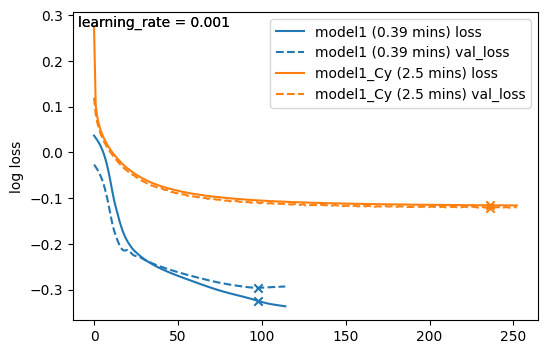

(<Figure size 600x400 with 1 Axes>, <Axes: ylabel='log loss'>)

In [18]:
idSysLin.plot_logs() # Plotting learning curve for fully linear DPAD

We then run inference with learned linear model:

In [19]:
# Predict behavior and neural activity, from past neural activity, using the learned model
print("Computing predictions for the learned linear model")
zTestPredLin, yTestPredLin, xTestPredLin = idSysLin.predict(yTest)

# Compute CC of decoding and self-prediction
zCCLin = evalPrediction(zTest, zTestPredLin, "CC")
yCCLin = evalPrediction(yTest, yTestPredLin, "CC")

print(
    f"Behavior decoding CC:\n  linear DPAD => {np.mean(zCCLin):.3g}"
)
print(
    f"Neural self-prediction CC:\n  linear DPAD => {np.mean(yCCLin):.3g}"
)

Computing predictions for the learned linear model
84/84 [==============================] - 0s 692us/step
Behavior decoding CC:
  linear DPAD => 0.676
Neural self-prediction CC:
  linear DPAD => 0.495


In [20]:
# Let's plot the prediction performance
def plotDecoding(zCCVals, labels, cols, zPerfMeasure="CC", title='Behavior decoding', ax=None, figsize=(4, 4)):
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(1, 1, 1)
    prepAxesStyle(ax)
    # Make bar plot of zCC values
    barlist = ax.bar(np.arange(len(zCCVals)), zCCVals, alpha=0.5)
    ax.set_xticks(np.arange(len(zCCVals)))
    ax.set_xticklabels([L.replace("_", "\n") for L in labels])
    for mi in range(len(barlist)):
        barlist[mi].set_color(cols[mi])
    ax.set_ylabel(f"{title} {zPerfMeasure}", fontsize=14)
    ax.set_xlabel("", fontsize=14)
    ax.set_title(title, fontsize=14)
    ax.tick_params(axis="both", labelsize=14)
    if ax is None:
        plt.show()

    plt.show()

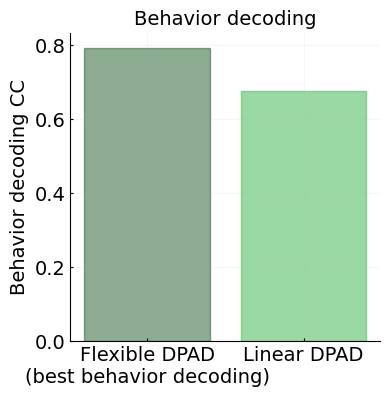

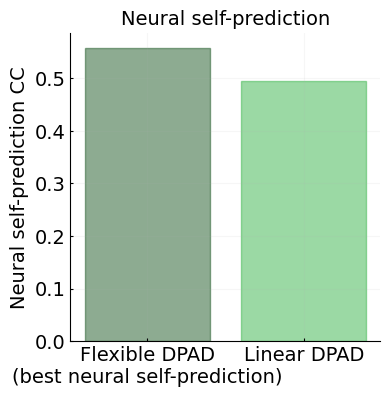

In [21]:

zCCValsL = [np.mean(zCCNonLinF), np.mean(zCCLin)] # Compute average CC across z dimensions
yCCValsL = [np.mean(yCCNonLinF_y), np.mean(yCCLin)] # Compute average CC across y dimensions
labelsL1 = ["Flexible DPAD\n(best behavior decoding)", "Linear DPAD"]
labelsL2 = ["Flexible DPAD\n(best neural self-prediction)", "Linear DPAD"]
colsL = ["#1d5925", "#39b54a"]
plotDecoding(zCCValsL, labelsL1, colsL, zPerfMeasure="CC", title='Behavior decoding', ax=None, figsize=(4, 4))
plotDecoding(yCCValsL, labelsL2, colsL, zPerfMeasure="CC", title='Neural self-prediction', ax=None, figsize=(4, 4))

# plotDecodingAndSelfPred(zCCValsL, yCCValsL, labelsL, colsL)